# DeepRacer Log Analysis for Model Training
(Compatible with Logs from the AWS DeepRacer Console after Aug 2020)
<br>
___

This Notebook is a redo of Log Analysis solutions provided in the [AWS DeepRacer Workshops repository](https://github.com/aws-samples/aws-deepracer-workshops). The log analysis here parses log data from AWS RoboMaker (SIM_TRACE_LOG data) and Amazon SageMaker (policy training data), and introduces some analyses that are not present in the AWS samples.

With the new AWS DeepRacer console update in Aug 2020, these logs are no longer streamed to CloudWatch Logs during training. Instead, they are downloadable from the model page in the AWS DeepRacer console, after training has terminated.

The code here:
- is compatible with downloaded logs from the new console (after Aug 2020).
- should be backwards compatible with DeepRacer logs previously downloaded from CloudWatch Logs too.
- is maintained such that it can be run directly from a Amazon SageMaker Notebook instance, as long as the relative paths of the RoboMaker and SageMaker log files are specified correctly.
- does not require access to any AWS Services (hence no awscli or boto required) when analysing the log data files.

In [1]:
!docker logs --tail all $(docker ps | awk ' /sagemaker/ { print $1 }') > /home/ubuntu/deepracer/github/deepracer-log-analysis/logs/local-sagemaker_50.log 2>&1
!docker logs --tail all $(docker ps | awk ' /robomaker/ { print $1 }') > /home/ubuntu/deepracer/github/deepracer-log-analysis/logs/local-robomaker_50.log 2>&1


In [2]:
# Check Python version
from platform import python_version
print(python_version())

3.6.10


# Import Required Packages

In [3]:
# Install pip packages in the current Jupyter kernel - for packages that are not installed by default
import sys
!{sys.executable} -m pip install shapely

# Add other packages here if import for them fails in the cell below, eg.:
#!{sys.executable} -m pip install numpy pandas matplotlib sklearn shapely boto3

Looking in indexes: http://ftp.daumkakao.com/pypi/simple


In [4]:
import math
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

# Shapely Library
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LineString

from os import listdir
from os.path import isfile, join
import os.path

pd.set_option('display.max_rows', 500, 'display.max_columns', None)

# Specify the RoboMaker & SageMaker Log File Locations

In [5]:
# SPECIFY THE RELATIVE PATH/FILENAMES HERE ACCORDINGLY:
# - robomaker_fname: location of the AWS RoboMaker log file
# - sagemaker_fname: location of the Amazon SageMaker log file
robomaker_fname = 'logs/local-robomaker_50.log'
sagemaker_fname = 'logs/local-sagemaker_50.log'

# Retrieve Training Parameters, Hyperparameters & Action Space from Logs

In [6]:
def parse_robomaker_logs_training_parameters(robomaker_fname, training_parameter_name):
    os_cmd = "cat %s | grep -E '^[{].*[}]$' | grep 'WORLD[_]NAME' | grep 'AWS[_]REGION' | sed \"s/[']/\"'\"/g' | head -1" % (robomaker_fname)
    os_output = !$os_cmd
    training_parameters = json.loads(os_output[0])
    return training_parameters[training_parameter_name]

In [7]:
# Retrieve Training Parameters
'''
try:
    # Works with RoboMaker logs from Aug 2020 onwards
    AWS_REGION = parse_robomaker_logs_training_parameters(robomaker_fname, 'AWS_REGION')
    WORLD_NAME = parse_robomaker_logs_training_parameters(robomaker_fname, 'WORLD_NAME')
    SIMTRACE_S3_PREFIX = parse_robomaker_logs_training_parameters(robomaker_fname, 'SIMTRACE_S3_PREFIX')

    os_cmd = "echo '%s' | sed -e 's/^.*[/]models[/]//g' | cut -d'/' -f1" % (SIMTRACE_S3_PREFIX)
    MODEL_NAME = !$os_cmd
    MODEL_NAME = MODEL_NAME[0]

except:
    # Works with older RoboMaker logs
    os_cmd = "cat %s | grep -E '[*][ ][/]AWS[_]REGION[:]' | head -1" % (robomaker_fname)
    AWS_REGION = !$os_cmd
    AWS_REGION = AWS_REGION[0].split(':')[-1].split(' ')[-1]

    os_cmd = "cat %s | grep -E 'gzserver.*[/]worlds[/].*[.]world' | head -1" % (robomaker_fname)
    WORLD_NAME = !$os_cmd
    WORLD_NAME = WORLD_NAME[0].split('/worlds/')[-1].split('.world')[0]

    os_cmd = "cat %s | grep -E 'Successfully[ ]downloaded[ ]model[ ]metadata.*[/]model[_]metadata[.]json' | head -1" % (robomaker_fname)
    MODEL_NAME = !$os_cmd
    MODEL_NAME = MODEL_NAME[0].split('/model_metadata.json')[0].split('/')[-1]
'''
    

AWS_REGION='US-EAST'
WORLD_NAME='Austin'
MODEL_NAME='LA01-234'

print ('AWS_REGION: %s' % AWS_REGION)
print ('WORLD_NAME: %s' % WORLD_NAME)
print ('MODEL_NAME: %s' % MODEL_NAME)    


AWS_REGION: US-EAST
WORLD_NAME: Austin
MODEL_NAME: LA01-234


In [8]:
def parse_robomaker_logs_hyperparameters(robomaker_fname, hyperparameter_name):
    hyperparameter_name = hyperparameter_name.replace('_', '[_]')
    os_cmd = "cat %s | grep -E '^[ ]+[\"]%s[\"][:]' | cut -d':' -f2 | cut -d',' -f1 | sed -e 's/^[ ]*//g'" % (robomaker_fname, hyperparameter_name)
    os_output = !$os_cmd
    return os_output[0]

In [9]:
# Retrieve Hyperparameters

EPISODES_PER_ITERATION = int(parse_robomaker_logs_hyperparameters(robomaker_fname, 'num_episodes_between_training'))
NUM_EPOCHS = int(parse_robomaker_logs_hyperparameters(robomaker_fname, 'num_epochs'))

print ('EPISODES_PER_ITERATION: %s' % EPISODES_PER_ITERATION)
print ('NUM_EPOCHS: %s' % NUM_EPOCHS)

EPISODES_PER_ITERATION: 40
NUM_EPOCHS: 10


In [10]:
# Retrieve Action Space

action_space = !grep '^Reward Distribution Graph.*racecar' $robomaker_fname
action_space = action_space[0].replace('Reward Distribution Graph:', '')
action_space = action_space.replace('racecar', '')
action_space = action_space.replace("'", '"')
action_space = json.loads(action_space)
#action_space = [{'speed': 1.5, 'index': 0, 'steering_angle': -30}, {'speed': 1.9704, 'index': 1, 'steering_angle': -12.7506}, {'speed': 2.8773, 'index': 2, 'steering_angle': -7.0501}, {'speed': 1.7831, 'index': 3, 'steering_angle': -0.6292}, {'speed': 3.9238, 'index': 4, 'steering_angle': -0.0239}, {'speed': 3.3736, 'index': 5, 'steering_angle': 0.875}, {'speed': 2.3195, 'index': 6, 'steering_angle': 6.1889}, {'speed': 2.8651, 'index': 7, 'steering_angle': 7.3838}, {'speed': 1.785, 'index': 8, 'steering_angle': 13.6619}, {'speed': 1.5, 'index': 9, 'steering_angle': 30}]
action_space

[{'steering_angle': -30.0, 'speed': 1.9, 'index': 0},
 {'steering_angle': -23.0, 'speed': 2.4, 'index': 1},
 {'steering_angle': -18.9, 'speed': 2.6, 'index': 2},
 {'steering_angle': -12.1, 'speed': 3.3, 'index': 3},
 {'steering_angle': -8.0, 'speed': 2.9, 'index': 4},
 {'steering_angle': -6.0, 'speed': 4.0, 'index': 5},
 {'steering_angle': -3.4, 'speed': 5.0, 'index': 6},
 {'steering_angle': -2.7, 'speed': 5.6, 'index': 7},
 {'steering_angle': -0.5, 'speed': 4.9, 'index': 8},
 {'steering_angle': -0.3, 'speed': 7.0, 'index': 9},
 {'steering_angle': 0, 'speed': 8.0, 'index': 10},
 {'steering_angle': 0.9, 'speed': 7.0, 'index': 11},
 {'steering_angle': 3.6, 'speed': 5.5, 'index': 12},
 {'steering_angle': 6.4, 'speed': 4.0, 'index': 13},
 {'steering_angle': 7.7, 'speed': 3.5, 'index': 14},
 {'steering_angle': 8.5, 'speed': 3.2, 'index': 15},
 {'steering_angle': 12.0, 'speed': 2.5, 'index': 16},
 {'steering_angle': 15.2, 'speed': 1.9, 'index': 17},
 {'steering_angle': 19.0, 'speed': 1.7, 'i

In [11]:
action_names = []
for action in action_space:
    action_steering = ('%+.1f' % action['steering_angle']).replace('+0.0', 'CENTER:0.0').replace('+','LEFT:').replace('-','RIGHT:')
    action_speed = ('SPD:%.2f' % action['speed'])
    action_names.append(action_steering + ' / ' + action_speed)
action_names

['RIGHT:30.0 / SPD:1.90',
 'RIGHT:23.0 / SPD:2.40',
 'RIGHT:18.9 / SPD:2.60',
 'RIGHT:12.1 / SPD:3.30',
 'RIGHT:8.0 / SPD:2.90',
 'RIGHT:6.0 / SPD:4.00',
 'RIGHT:3.4 / SPD:5.00',
 'RIGHT:2.7 / SPD:5.60',
 'RIGHT:0.5 / SPD:4.90',
 'RIGHT:0.3 / SPD:7.00',
 'CENTER:0.0 / SPD:8.00',
 'LEFT:0.9 / SPD:7.00',
 'LEFT:3.6 / SPD:5.50',
 'LEFT:6.4 / SPD:4.00',
 'LEFT:7.7 / SPD:3.50',
 'LEFT:8.5 / SPD:3.20',
 'LEFT:12.0 / SPD:2.50',
 'LEFT:15.2 / SPD:1.90',
 'LEFT:19.0 / SPD:1.70',
 'LEFT:23.0 / SPD:1.60',
 'LEFT:30.0 / SPD:1.50']

In [12]:
action_speed = list()
action_steering = list()

for action in action_space:
    action_speed.append(action['speed'])
    action_steering.append(action['steering_angle'])

print ('SPEED: %s' % action_speed)
print ('STEERING: %s' % action_steering)

action_min_speed = min(action_speed)
action_max_speed = max(action_speed)
action_min_steering = min(action_steering)
action_max_steering = max(action_steering)

print ('MIN SPEED: %f' % action_min_speed)
print ('MAX SPEED: %f' % action_max_speed)
print ('MIN STEERING: %f' % action_min_steering)
print ('MAX STEERING: %f' % action_max_steering)

action_speed_range = action_max_speed - action_min_speed
action_steering_range = action_max_steering - action_min_steering

print ('SPEED RANGE: %f' % action_speed_range)
print ('STEERING RANGE: %f' % action_steering_range)


SPEED: [1.9, 2.4, 2.6, 3.3, 2.9, 4.0, 5.0, 5.6, 4.9, 7.0, 8.0, 7.0, 5.5, 4.0, 3.5, 3.2, 2.5, 1.9, 1.7, 1.6, 1.5]
STEERING: [-30.0, -23.0, -18.9, -12.1, -8.0, -6.0, -3.4, -2.7, -0.5, -0.3, 0, 0.9, 3.6, 6.4, 7.7, 8.5, 12.0, 15.2, 19.0, 23.0, 30.0]
MIN SPEED: 1.500000
MAX SPEED: 8.000000
MIN STEERING: -30.000000
MAX STEERING: 30.000000
SPEED RANGE: 6.500000
STEERING RANGE: 60.000000


# Parse *Simulation* Job (AWS RoboMaker) Logs

In [13]:
# Check that the RoboMaker Log file exists

print('RoboMaker Log file size: %d' % os.stat(robomaker_fname).st_size)
!tail $robomaker_fname

RoboMaker Log file size: 60313606
SIM_TRACE_LOG:3696,130,-4.3977,-2.8401,43.1831,-8.00,2.90,4,0.0010,False,True,31.7415,24,59.35,1606521427.930644,in_progress

SIM_TRACE_LOG:3696,131,-4.2915,-2.7556,40.9467,-8.00,2.90,4,0.0010,False,True,32.3072,26,59.35,1606521428.007939,in_progress

SIM_TRACE_LOG:3696,132,-4.1331,-2.6465,36.7987,-0.50,4.90,8,0.0010,False,True,32.7447,28,59.35,1606521428.0680783,in_progress

SIM_TRACE_LOG:3696,133,-3.9755,-2.5493,33.4992,15.20,1.90,17,0.0010,False,True,33.1555,29,59.35,1606521428.1403682,in_progress

SIM_TRACE_LOG:3696,134,-3.8113,-2.4473,32.1174,-23.00,2.40,1,0.0010,False,True,33.4727,30,59.35,1606521428.2030077,in_progress



In [14]:
# Retrieve SIM_TRACE_LOGs from the RoboMaker Log file

sim_data = []
with open(robomaker_fname, 'r') as f:
    for line in f.readlines():
        if "SIM_TRACE_LOG" in line:
            parts = line.split("SIM_TRACE_LOG:")[1].split('\t')[0].split('\n')[0].split(",")
            sim_data.append(",".join(parts))
sim_data[-20:]

['3696,115,-6.2426,-4.3996,3.6124,-3.40,5.00,6,1.4738,False,True,27.2444,15,59.35,1606521426.9094288,in_progress',
 '3696,116,-6.1787,-4.3849,6.1132,23.00,1.60,19,2.9689,False,True,27.4236,15,59.35,1606521426.9807293,in_progress',
 '3696,117,-5.9595,-4.3069,16.7132,12.00,2.50,16,3.3664,False,True,27.8977,17,59.35,1606521427.0368705,in_progress',
 '3696,118,-5.8952,-4.2762,19.3964,-8.00,2.90,4,2.3534,False,True,28.0917,17,59.35,1606521427.1040506,in_progress',
 '3696,119,-5.7348,-4.1825,25.9981,6.40,4.00,13,1.5432,False,True,28.4002,18,59.35,1606521427.1745787,in_progress',
 '3696,120,-5.6004,-4.0923,30.4585,3.60,5.50,12,1.5494,False,True,28.7287,18,59.35,1606521427.2593915,in_progress',
 '3696,121,-5.4352,-3.9600,36.4193,19.00,1.70,18,0.0010,False,True,29.0715,19,59.35,1606521427.3269484,in_progress',
 '3696,122,-5.3665,-3.8944,39.4992,-23.00,2.40,1,0.0010,False,True,29.2415,19,59.35,1606521427.423917,in_progress',
 '3696,123,-5.2008,-3.7174,45.1291,-8.00,2.90,4,0.0010,False,True,29.62

In [15]:
# Parse the SIM_TRACE_LOG data

df_list = list()

# Ignore the first two dummy values that coach throws at the start
# (not sure if it's still necessary to do so?)
for d in sim_data[2:]:
    parts = d.rstrip().split(",")
    episode = int(parts[0])
    steps = int(parts[1])
    x = 100*float(parts[2])
    y = 100*float(parts[3])
    ##cWp = get_closest_waypoint(x, y, wpts)
    yaw = float(parts[4])
    steer = float(parts[5])
    throttle = float(parts[6])
    action = float(parts[7])
    reward = float(parts[8])
    done = 0 if 'False' in parts[9] else 1
    all_wheels_on_track = parts[10]
    progress = float(parts[11])
    closest_waypoint = int(parts[12])
    track_len = float(parts[13])
    tstamp = float(parts[14])
    status = parts[15]

    #iteration = int(episode / EPISODES_PER_ITERATION) + 1
    iteration = int(episode / EPISODES_PER_ITERATION) # remove 1
    if (iteration == 0) and (episode == 0):
        steps -= 2
    episode_in_iteration = (episode % EPISODES_PER_ITERATION) + 1
    episode += 1
    df_list.append((iteration, episode_in_iteration, episode, steps, x, y, yaw, steer, throttle, action, reward, done, all_wheels_on_track, progress,
                    closest_waypoint, track_len, tstamp, status))

header = ['iteration', 'episode_in_iteration', 'episode', 'steps', 'x', 'y', 'yaw', 'steer', 'throttle', 'action', 'reward', 'done', 'on_track', 'progress', 'closest_waypoint', 'track_len', 'timestamp', 'status']
sim_df = pd.DataFrame(df_list, columns=header)
sim_df

iteration  episode_in_iteration  episode  steps       x       y  \
0               0                     1        1      1 -864.72 -150.92   
1               0                     1        1      2 -863.76 -152.99   
2               0                     1        1      3 -861.77 -157.44   
3               0                     1        1      4 -857.40 -167.30   
4               0                     1        1      5 -855.83 -171.02   
...           ...                   ...      ...    ...     ...     ...   
466484         92                    17     3697    130 -439.77 -284.01   
466485         92                    17     3697    131 -429.15 -275.56   
466486         92                    17     3697    132 -413.31 -264.65   
466487         92                    17     3697    133 -397.55 -254.93   
466488         92                    17     3697    134 -381.13 -244.73   

            yaw  steer  throttle  action  reward  done on_track  progress  \
0      -62.6841   -8.0       2.9     4.0  0.0010     0     True    0.2744   
1      -62.8388    0.0       8.0    10.0  2.4834     0     True    0.3128   
2      -63.4950    0.0       8.0    10.0  2.4801     0     True    0.3947   
3      -64.5362   -3.4       5.0     6.0  0.0010     0     True    0.5762   
4      -65.0159  -23.0       2.4     1.0  0.0010     0     True    0.6440   
...         ...    ...       ...     ...     ...   ...      ...       ...   
466484  43.1831   -8.0       2.9     4.0  0.0010     0     True   31.7415   
466485  40.9467   -8.0       2.9     4.0  0.0010     0     True   32.3072   
466486  36.7987   -0.5       4.9     8.0  0.0010     0     True   32.7447   
466487  33.4992   15.2       1.9    17.0  0.0010     0     True   33.1555   
466488  32.1174  -23.0       2.4     1.0  0.0010     0     True   33.4727   

        closest_waypoint  track_len     timestamp       status  
0                      1      59.35  1.606481e+09  in_progress  
1                      1      59.35  1.606481e+09  in_progress  
2                      1      59.35  1.606481e+09  in_progress  
3                      1      59.35  1.606481e+09  in_progress  
4                      1      59.35  1.606481e+09  in_progress  
...                  ...        ...           ...          ...  
466484                24      59.35  1.606521e+09  in_progress  
466485                26      59.35  1.606521e+09  in_progress  
466486                28      59.35  1.606521e+09  in_progress  
466487                29      59.35  1.606521e+09  in_progress  
466488                30      59.35  1.606521e+09  in_progress  

[466489 rows x 18 columns]

In [16]:
# Calculate episode-related data

sim_df_episodes = sim_df[sim_df["done"] == 1][["iteration", "episode_in_iteration", "episode", "steps", "progress", "status"]].copy()
sim_df_episodes["episode_total_rewards"] = sim_df.groupby("episode")["reward"].transform("sum")
sim_df_episodes["elapsed_time"] = sim_df.groupby("episode")["timestamp"].transform("max") - sim_df.groupby("episode")["timestamp"].transform("min")
sim_df_episodes["start_time"] = sim_df.groupby("episode")["timestamp"].transform("min")
sim_df_episodes["end_time"] = sim_df.groupby("episode")["timestamp"].transform("max")

sim_df_episodes[sim_df_episodes['episode_in_iteration']==1]

iteration  episode_in_iteration  episode  steps  progress     status  \
253             0                     1        1    254   68.3077  off_track   
4274            1                     1       41     75   18.7120  off_track   
8254            2                     1       81    259   66.8996  off_track   
12283           3                     1      121    114   26.0256  off_track   
16856           4                     1      161     50   10.9587  off_track   
21474           5                     1      201     39    8.7384  off_track   
25405           6                     1      241     69   16.2220  off_track   
29509           7                     1      281    101   29.4021  off_track   
35107           8                     1      321    208   51.4315  off_track   
39913           9                     1      361    258   65.1101  off_track   
44150          10                     1      401     73   15.7885  off_track   
48584          11                     1      441    267   68.5554  off_track   
53417          12                     1      481    248   63.5270  off_track   
58612          13                     1      521    271   69.5999  off_track   
63387          14                     1      561    125   27.8576  off_track   
68240          15                     1      601    281   67.7940  off_track   
73446          16                     1      641    243   62.1138  off_track   
78105          17                     1      681     83   12.2091  off_track   
82913          18                     1      721    260   63.9922  off_track   
87633          19                     1      761    265   65.9052  off_track   
93362          20                     1      801    100   25.4075  off_track   
97254          21                     1      841    203   51.7727  off_track   
102442         22                     1      881    144   37.1850  off_track   
106767         23                     1      921    112   27.6307  off_track   
111520         24                     1      961    105   24.9024  off_track   
116671         25                     1     1001    235   64.5564  off_track   
121032         26                     1     1041    104   27.0090  off_track   
125731         27                     1     1081     31    6.6650  off_track   
129872         28                     1     1121    199   49.9915  off_track   
134793         29                     1     1161    180   46.0838  off_track   
139597         30                     1     1201     20    2.6003  off_track   
144997         31                     1     1241     65   12.2506  off_track   
150432         32                     1     1281     99   27.0194  off_track   
155557         33                     1     1321    189   45.2898  off_track   
160184         34                     1     1361     76   18.9168  off_track   
165170         35                     1     1401    245   65.7577  off_track   
170539         36                     1     1441    217   56.0951  off_track   
175955         37                     1     1481    272   69.9079  off_track   
181461         38                     1     1521     75   15.3497  off_track   
186841         39                     1     1561    240   60.3486  off_track   
192000         40                     1     1601    324   77.7306  off_track   
196714         41                     1     1641    221   64.6758  off_track   
202264         42                     1     1681    266   70.2879  off_track   
206384         43                     1     1721    209   50.2492  off_track   
210744         44                     1     1761     75   22.7740  off_track   
215851         45                     1     1801     72   17.6461  off_track   
220760         46                     1     1841      1    0.2362  off_track   
225825         47                     1     1881    281   70.2178  off_track   
231168         48                     1     1921     74   17.1799  off_track   
236940  

In [17]:
# Calculate iteration-related data

sim_df_iterations = sim_df_episodes[sim_df_episodes["episode_in_iteration"] == 1][["iteration"]].copy()
sim_df_iterations["min_progress"] = sim_df_episodes.groupby("iteration")["progress"].transform("min")
sim_df_iterations["max_progress"] = sim_df_episodes.groupby("iteration")["progress"].transform("max")
sim_df_iterations["avg_progress"] = sim_df_episodes.groupby("iteration")["progress"].transform("mean")
sim_df_iterations["total_rewards"] = sim_df.groupby("iteration")["reward"].transform("sum")
sim_df_iterations["start_time"] = sim_df_episodes.groupby("iteration")["start_time"].transform("min")
sim_df_iterations["end_time"] = sim_df_episodes.groupby("iteration")["end_time"].transform("max")

lap_count = sim_df_episodes[sim_df_episodes["progress"] >= 100.0].groupby("iteration")["progress"].count()
sim_df_iterations = pd.merge(sim_df_iterations,lap_count,on="iteration",how="outer")
sim_df_iterations.rename(columns={"progress":"completed_laps"}, inplace=True)
sim_df_iterations["completed_laps"].fillna(0, inplace=True)
sim_df_iterations["completed_laps"] = sim_df_iterations["completed_laps"].astype(int)

episode_count = sim_df_episodes.groupby("iteration")["episode_in_iteration"].count()
sim_df_iterations = pd.merge(sim_df_iterations,episode_count,on="iteration",how="outer")
sim_df_iterations.rename(columns={"episode_in_iteration":"episodes"}, inplace=True)
sim_df_iterations["pct_completed_laps"] = (sim_df_iterations["completed_laps"] / sim_df_iterations["episodes"] * 100.0)

if (sim_df_iterations.tail(1)['episodes'].values[0] < EPISODES_PER_ITERATION):
    sim_df_iterations.drop(sim_df_iterations.tail(1).index,inplace=True)
sim_df_iterations

iteration  min_progress  max_progress  avg_progress  total_rewards  \
0           0        4.1525       91.8534     25.060245      3156.4174   
1           1        2.9827       81.3688     22.638162      2834.8039   
2           2        2.5165       67.2174     24.922910      3014.3344   
3           3        1.5005       94.7931     27.525875      3389.5069   
4           4        3.0595       89.7629     27.409645      3546.6392   
5           5        4.2535       90.9955     22.511190      2953.0836   
6           6        0.2360       75.4617     24.553500      3121.4389   
7           7        3.2007      100.0000     33.141350      4264.6312   
8           8        3.5270       79.6030     27.464092      3167.0895   
9           9        1.8316       80.5507     26.034170      3138.2195   
10         10        0.2355       86.5803     24.785510      3263.0482   
11         11        0.2363      100.0000     28.366647      3404.6233   
12         12        4.7373       91.1967     30.789825      3887.1451   
13         13        0.2362      100.0000     29.453855      3690.4180   
14         14        0.2346       77.0454     28.235910      3564.9079   
15         15        4.6958       80.3517     31.509340      3873.8283   
16         16        0.2362       88.1172     28.772293      3550.2309   
17         17        5.6322       89.5999     27.669198      3430.1608   
18         18        5.3357       69.6000     28.254235      3662.7079   
19         19        0.2320      100.0000     35.271370      4292.9060   
20         20        1.7242       82.8952     22.209808      2755.9530   
21         21        3.0537       94.3767     31.291680      3968.9684   
22         22        0.2361      100.0000     26.184545      3525.9451   
23         23        0.2362       90.1211     28.155690      3532.3373   
24         24        4.8778       85.1474     30.370578      4091.1626   
25         25        0.2363       95.2178     26.606145      3422.8727   
26         26        4.7405       99.2911     28.079982      3583.1122   
27         27        4.2826       70.6092     23.072448      2772.8068   
28         28        4.6853       83.7364     29.896585      3788.5440   
29         29        4.4390       89.5999     29.149517      3716.2036   
30         30        2.6003       95.1101     32.349812      4157.0898   
31         31        5.2841       94.5999     32.172680      4123.8008   
32         32        2.8097      100.0000     30.119393      3973.1446   
33         33        4.3171       81.8526     27.853433      3556.5399   
34         34        3.6983       90.5507     28.925965      3735.6849   
35         35        5.9013       95.0897     32.055015      3985.4578   
36         36        3.7735       83.8890     32.432668      3953.1773   
37         37        3.3281      100.0000     33.873180      4488.2443   
38         38        0.2362       94.9079     31.125015      3955.1280   
39         39        3.7047       90.7923     30.250500      3776.8696   
40         40        4.1902       77.7306     28.957755      3626.5378   
41         41        3.4029       95.4831     33.514052      4156.6575   
42         42        4.4885       70.2879     24.708040      3078.6118   
43         43        0.2361       86.2577     25.738435      2982.5405   
44         44        0.2359       96.7995     30.422900      3602.3770   
45         45        2.5196       80.8112     30.270610      4242.6394   
46         46        0.2362       91.3927     28.643862      3636.0101   
47         47        4.6777      100.0000     33.396262      4272.6855   
48         48        4.2496       89.2911     34.560623      4626.6522   
49         49        2.7967       88.5554     31.449680      4116.1023   
50         50        0.2363       94.2911     31.128550      4273.2185   
51         51        1.4234       94.6703     30.582110      3967.9409   
52         52        4.3151      100.0000     29.449485      3755.6145   
53      

In [18]:
# Calculate aggregated values for iterations

x = sim_df_iterations[['total_rewards']].values.astype(float)
if (len(x)>0):
    min_max_scaler = MinMaxScaler(feature_range=(5,95))
    x_scaled = min_max_scaler.fit_transform(x)
    sim_df_iterations['total_rewards_normalized'] = x_scaled
    sim_df_iterations

In [19]:
print ('%d' % len(sim_df_iterations))
if (len(sim_df_iterations) > 0):
    sim_df_iterations['total_rewards_normalized_SMA3'] = sim_df_iterations['total_rewards_normalized'].rolling(window=3).mean()
    sim_df_iterations['min_progress_SMA3'] = sim_df_iterations['min_progress'].rolling(window=3).mean()
    sim_df_iterations['max_progress_SMA3'] = sim_df_iterations['max_progress'].rolling(window=3).mean()
    sim_df_iterations['avg_progress_SMA3'] = sim_df_iterations['avg_progress'].rolling(window=3).mean()
    sim_df_iterations['pct_completed_laps_SMA3'] = sim_df_iterations['pct_completed_laps'].rolling(window=3).mean()

sim_df_iterations

92


iteration  min_progress  max_progress  avg_progress  total_rewards  \
0           0        4.1525       91.8534     25.060245      3156.4174   
1           1        2.9827       81.3688     22.638162      2834.8039   
2           2        2.5165       67.2174     24.922910      3014.3344   
3           3        1.5005       94.7931     27.525875      3389.5069   
4           4        3.0595       89.7629     27.409645      3546.6392   
5           5        4.2535       90.9955     22.511190      2953.0836   
6           6        0.2360       75.4617     24.553500      3121.4389   
7           7        3.2007      100.0000     33.141350      4264.6312   
8           8        3.5270       79.6030     27.464092      3167.0895   
9           9        1.8316       80.5507     26.034170      3138.2195   
10         10        0.2355       86.5803     24.785510      3263.0482   
11         11        0.2363      100.0000     28.366647      3404.6233   
12         12        4.7373       91.1967     30.789825      3887.1451   
13         13        0.2362      100.0000     29.453855      3690.4180   
14         14        0.2346       77.0454     28.235910      3564.9079   
15         15        4.6958       80.3517     31.509340      3873.8283   
16         16        0.2362       88.1172     28.772293      3550.2309   
17         17        5.6322       89.5999     27.669198      3430.1608   
18         18        5.3357       69.6000     28.254235      3662.7079   
19         19        0.2320      100.0000     35.271370      4292.9060   
20         20        1.7242       82.8952     22.209808      2755.9530   
21         21        3.0537       94.3767     31.291680      3968.9684   
22         22        0.2361      100.0000     26.184545      3525.9451   
23         23        0.2362       90.1211     28.155690      3532.3373   
24         24        4.8778       85.1474     30.370578      4091.1626   
25         25        0.2363       95.2178     26.606145      3422.8727   
26         26        4.7405       99.2911     28.079982      3583.1122   
27         27        4.2826       70.6092     23.072448      2772.8068   
28         28        4.6853       83.7364     29.896585      3788.5440   
29         29        4.4390       89.5999     29.149517      3716.2036   
30         30        2.6003       95.1101     32.349812      4157.0898   
31         31        5.2841       94.5999     32.172680      4123.8008   
32         32        2.8097      100.0000     30.119393      3973.1446   
33         33        4.3171       81.8526     27.853433      3556.5399   
34         34        3.6983       90.5507     28.925965      3735.6849   
35         35        5.9013       95.0897     32.055015      3985.4578   
36         36        3.7735       83.8890     32.432668      3953.1773   
37         37        3.3281      100.0000     33.873180      4488.2443   
38         38        0.2362       94.9079     31.125015      3955.1280   
39         39        3.7047       90.7923     30.250500      3776.8696   
40         40        4.1902       77.7306     28.957755      3626.5378   
41         41        3.4029       95.4831     33.514052      4156.6575   
42         42        4.4885       70.2879     24.708040      3078.6118   
43         43        0.2361       86.2577     25.738435      2982.5405   
44         44        0.2359       96.7995     30.422900      3602.3770   
45         45        2.5196       80.8112     30.270610      4242.6394   
46         46        0.2362       91.3927     28.643862      3636.0101   
47         47        4.6777      100.0000     33.396262      4272.6855   
48         48        4.2496       89.2911     34.560623      4626.6522   
49         49        2.7967       88.5554     31.449680      4116.1023   
50         50        0.2363       94.2911     31.128550      4273.2185   
51         51        1.4234       94.6703     30.582110      3967.9409   
52         52        4.3151      100.0000     29.449485      3755.6145   
53      

# Parse *Training* Job (Amazon SageMaker) Logs

In [20]:
# Check that the SageMaker Log file exists

print('SageMaker Log file size: %d' % os.stat(sagemaker_fname).st_size)
!tail $sagemaker_fname

SageMaker Log file size: 617645












In [21]:
# Retrieve policy training data from the SageMaker Log file

trn_data = []
last_iteration_id = 0
with open(sagemaker_fname, 'r') as f:
    for line in f.readlines():
        if "Training> Name=main_level/agent, " in line:
            parts = line.split("Training> Name=main_level/agent, ")[1].split('\t')[0].split('\n')[0].split(',')
            last_iteration_id = [parts[-1].split('=')[1]]
        if "Policy training> " in line:
            parts = line.split("Policy training> ")[1].split('\t')[0].split('\n')[0].split(',')
            parts = [x.split('=')[1] for x in parts]
            trn_data.append(",".join(last_iteration_id + parts))
trn_data[1:20]

['0,-0.009712496772408485,0.000545328832231462,0.48823484778404236,1,5e-06',
 '0,-0.018329469487071037,0.001091244164854288,0.48658066987991333,2,5e-06',
 '0,-0.02373415231704712,0.0015536289429292083,0.48573219776153564,3,5e-06',
 '0,-0.022004663944244385,0.0018437771359458566,0.487471342086792,4,5e-06',
 '0,-0.026295198127627373,0.002127986866980791,0.4874107837677002,5,5e-06',
 '0,-0.027793217450380325,0.002410401590168476,0.4874545931816101,6,5e-06',
 '0,-0.03650711476802826,0.0026508495211601257,0.48583903908729553,7,5e-06',
 '0,-0.03714460879564285,0.003007361199706793,0.4884468913078308,8,5e-06',
 '0,-0.03569693863391876,0.003392584854736924,0.4886394441127777,9,5e-06',
 '1,-0.0021076176781207323,2.5382958483533002e-05,0.5070186853408813,0,5e-06',
 '1,-0.0066225421614944935,0.00023722542391624302,0.5069319009780884,1,5e-06',
 '1,-0.015450404956936836,0.0007208282477222383,0.5024461150169373,2,5e-06',
 '1,-0.025857284665107727,0.0012797897215932608,0.5046382546424866,3,5e-06',
 '

In [22]:
# Parse the policy training data

df_list = list()

for d in trn_data:
    parts = d.rstrip().split(",")
    iteration = int(parts[0]) + 1 # add 1 so as to match model.pb (training iteration n == model.pb n+1)
    surrogate_loss = float(parts[1])
    kl_divergence = float(parts[2])
    entropy = float(parts[3])
    training_epoch = int(parts[4]) + 1
    learning_rate = float(parts[5])

    df_list.append((iteration, surrogate_loss, kl_divergence, entropy, training_epoch, learning_rate))

header = ['iteration', 'surrogate_loss', 'kl_divergence', 'entropy', 'training_epoch', 'learning_rate']
trn_df = pd.DataFrame(df_list, columns=header)
trn_df

iteration  surrogate_loss  kl_divergence   entropy  training_epoch  \
0            1        0.003927       0.000156  0.488026               1   
1            1       -0.009712       0.000545  0.488235               2   
2            1       -0.018329       0.001091  0.486581               3   
3            1       -0.023734       0.001554  0.485732               4   
4            1       -0.022005       0.001844  0.487471               5   
..         ...             ...            ...       ...             ...   
915         92       -0.024921       0.002370  0.553557               6   
916         92       -0.027745       0.002698  0.551482               7   
917         92       -0.038204       0.003098  0.554116               8   
918         92       -0.036864       0.003246  0.553903               9   
919         92       -0.039980       0.003611  0.555073              10   

     learning_rate  
0         0.000005  
1         0.000005  
2         0.000005  
3         0.000005  
4         0.000005  
..             ...  
915       0.000005  
916       0.000005  
917       0.000005  
918       0.000005  
919       0.000005  

[920 rows x 6 columns]

In [23]:
# Calculate aggregated values for iterations

if (len(trn_df)>0):
    trn_df["avg_entropy"] = trn_df.groupby("iteration")["entropy"].transform("mean")
    trn_df_entropy = trn_df[trn_df["training_epoch"] == 1][['iteration', 'avg_entropy']]

trn_df_entropy['avg_entropy_SMA3'] = trn_df_entropy.iloc[:,1].rolling(window=3).mean()
trn_df_entropy

iteration  avg_entropy  avg_entropy_SMA3
0            1     0.487384               NaN
10           2     0.504787               NaN
20           3     0.486937          0.493036
30           4     0.479001          0.490242
40           5     0.484957          0.483632
50           6     0.467121          0.477026
60           7     0.516109          0.489396
70           8     0.501394          0.494875
80           9     0.479197          0.498900
90          10     0.486584          0.489058
100         11     0.465875          0.477219
110         12     0.471456          0.474638
120         13     0.485195          0.474175
130         14     0.507291          0.487981
140         15     0.504419          0.498968
150         16     0.496346          0.502685
160         17     0.511365          0.504043
170         18     0.483526          0.497079
180         19     0.490297          0.495063
190         20     0.494937          0.489587
200         21     0.507972          0.497735
210         22     0.497127          0.500012
220         23     0.497333          0.500811
230         24     0.483966          0.492809
240         25     0.498080          0.493126
250         26     0.481956          0.488001
260         27     0.514957          0.498331
270         28     0.488150          0.495021
280         29     0.518086          0.507064
290         30     0.508621          0.504952
300         31     0.501160          0.509289
310         32     0.514150          0.507977
320         33     0.508555          0.507955
330         34     0.509657          0.510787
340         35     0.531583          0.516598
350         36     0.508310          0.516517
360         37     0.521141          0.520345
370         38     0.494438          0.507963
380         39     0.496383          0.503987
390         40     0.511193          0.500671
400         41     0.533353          0.513643
410         42     0.524618          0.523055
420         43     0.523980          0.527317
430         44     0.519889          0.522829
440         45     0.500398          0.514755
450         46     0.503812          0.508033
460         47     0.520391          0.508200
470         48     0.512944          0.512382
480         49     0.531621          0.521652
490         50     0.513828          0.519464
500         51     0.507569          0.517673
510         52     0.504288          0.508562
520         53     0.529794          0.513884
530         54     0.508347          0.514143
540         55     0.523898          0.520680
550         56     0.510629          0.514291
560         57     0.497243          0.510590
570         58     0.534142          0.514005
580         59     0.510736          0.514040
590         60     0.524517          0.523132
600         61     0.520914          0.518722
610         62     0.537065          0.527499
620         63     0.531343          0.529774
630         64     0.537314          0.535241
640         65     0.513731          0.527463
650         66     0.551584          0.534210
660         67     0.512802          0.526039
670         68     0.498877          0.521088
680         69     0.526979          0.512886
690         70     0.512547          0.512801
700         71     0.537224          0.525583
710         72     0.537012          0.528928
720         73     0.520770          0.531669
730         74     0.528288          0.528690
740         75     0.528711          0.525923
750         76     0.541126          0.532708
760         77     0.544081          0.537973
770         78     0.545939          0.543715
780         79     0.545392          0.545137
790         80     0.555821          0.549050
800         81     0.557333          0.552849
810         82     0.525329          0.546161
820         83     0.544597          0.542420
830         84     0.535904          0.535277
840         85     0.526006          0.535502
850         86     0.525581          0.529164
860

# Check Convergence - Plot Rewards vs Episodes/Iterations

Number of episodes =  3697
Number of complete iterations =  91


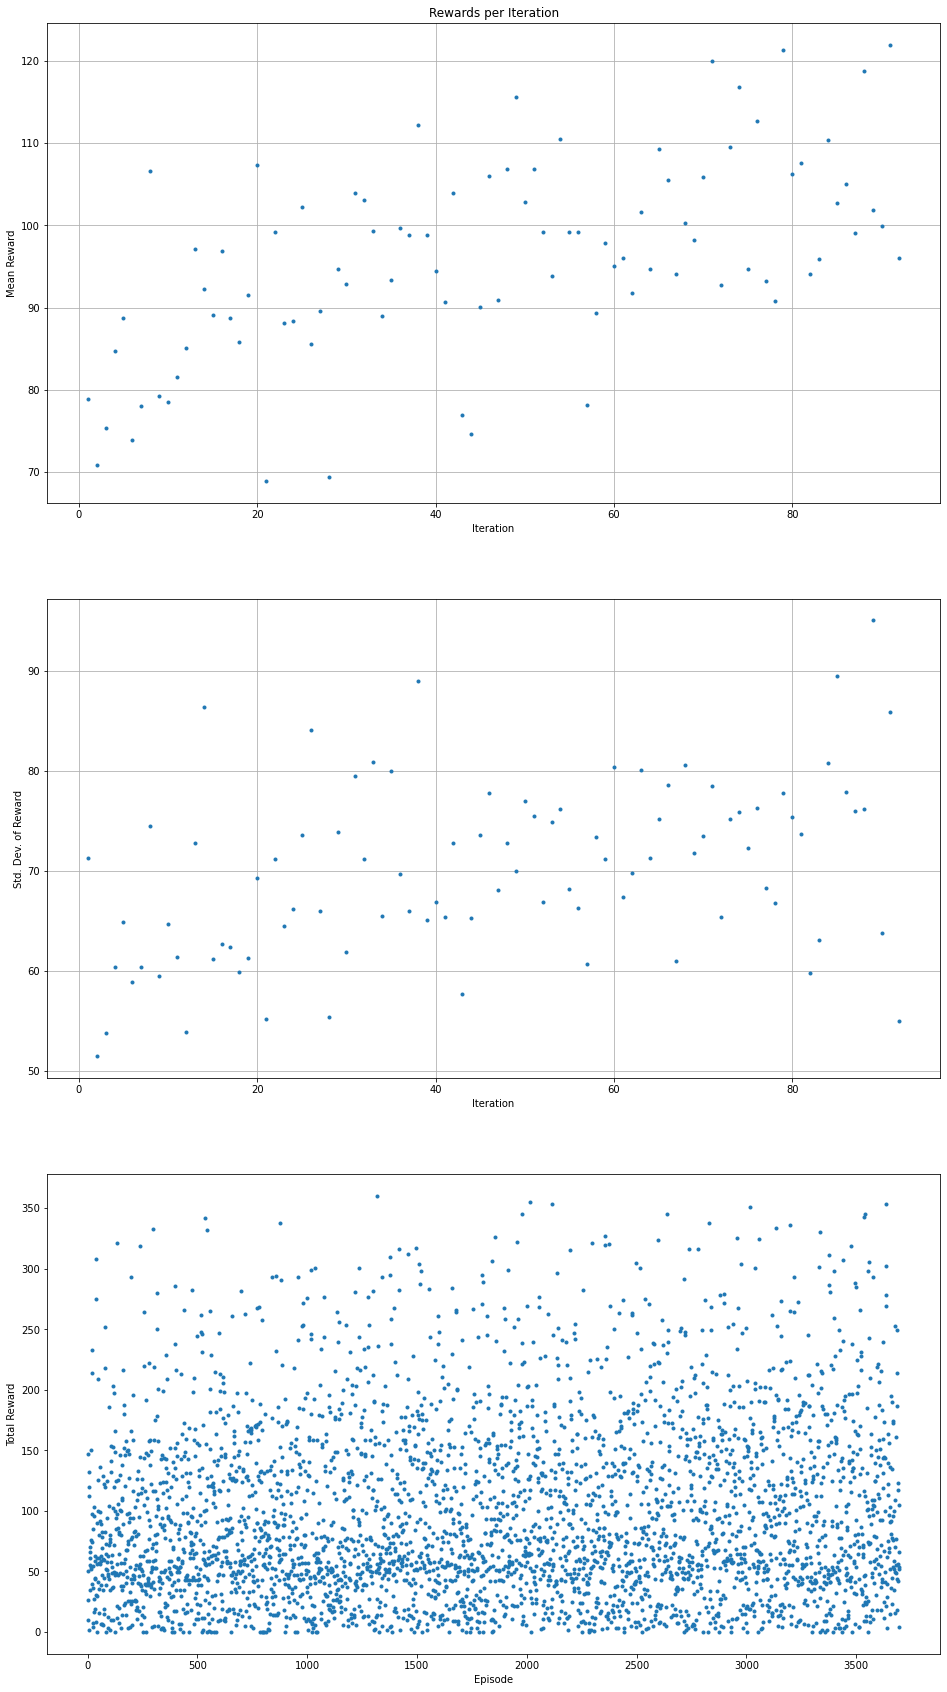

In [24]:
# Reward graph per episode
max_episode = np.max(sim_df['episode'])
max_iteration = np.max(sim_df_iterations['iteration'])
print('Number of episodes = ', max_episode)
print('Number of complete iterations = ', max_iteration)

total_reward_per_episode = list()
for epi in range(1, max_episode + 1):
    df_slice = sim_df[sim_df['episode'] == epi]
    total_reward_per_episode.append(np.sum(df_slice['reward']))

average_reward_per_iteration = list()
deviation_reward_per_iteration = list()

buffer_rew = list()
for val in total_reward_per_episode:
    buffer_rew.append(val)

    if len(buffer_rew) == EPISODES_PER_ITERATION:
        average_reward_per_iteration.append(np.mean(buffer_rew))
        deviation_reward_per_iteration.append(np.std(buffer_rew))
        # reset
        buffer_rew = list()

fig = plt.figure(figsize=(16, 10*3))
ax = fig.add_subplot(311)
ax.plot(np.arange(len(average_reward_per_iteration))+1, average_reward_per_iteration, '.')
ax.set_title('Rewards per Iteration')
ax.set_ylabel('Mean Reward')
ax.set_xlabel('Iteration')
plt.grid(True)

ax = fig.add_subplot(312)
ax.plot(np.arange(len(deviation_reward_per_iteration))+1, deviation_reward_per_iteration, '.')
ax.set_ylabel('Std. Dev. of Reward')
ax.set_xlabel('Iteration')
plt.grid(True)

ax = fig.add_subplot(313)
ax.plot(np.arange(len(total_reward_per_episode))+1, total_reward_per_episode, '.')
ax.set_ylabel('Total Reward')
ax.set_xlabel('Episode')
plt.grid(False)

# Check Correlation Between Steps and Lap Times
- Plot steps vs lap times to gauge the potential increasae in lap time for every step taken; this can also be used to extrapolate the target number of steps needed in order to achieve a certain lap time

# Check that Rewards Correlate with Performance
- Plot rewards vs lap times as a sanity check for our Reward Function logic

# Determine the Performance Envelope of the Model
- Plot a histogram of lap times to work out statistically the average and best-case lap times (also helps to confirm if the lap times within the performance envelope of the model resembles a normal distribution)
- The -2 and -3 Std Dev markers show the potential best-case lap times for the model

Completed Episodes: 16
62
Mean: 27.020870
Variance: 1.807145
StdDev: 1.344301
-2 StdDev: 25.077604
-3 StdDev: 24.841833


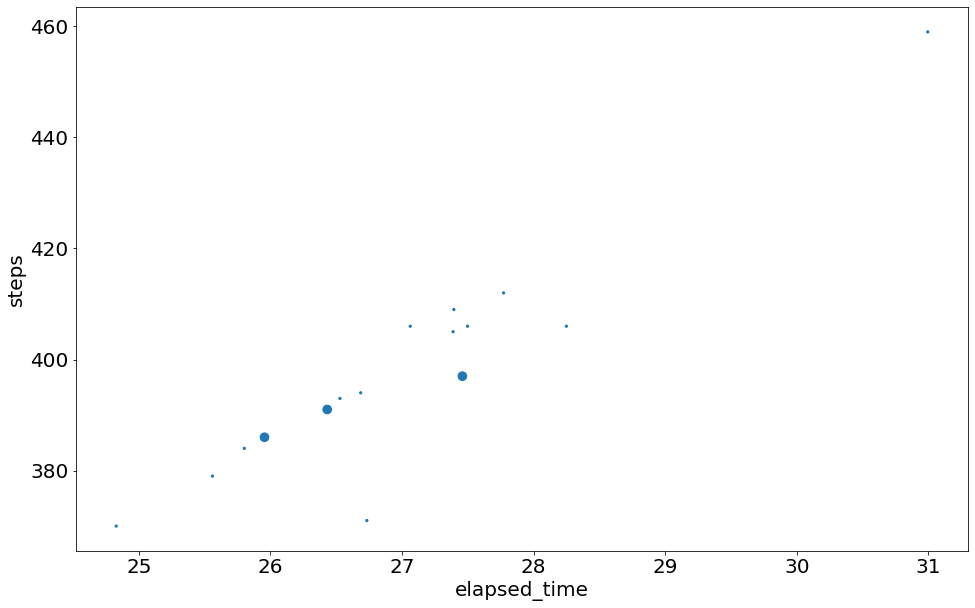

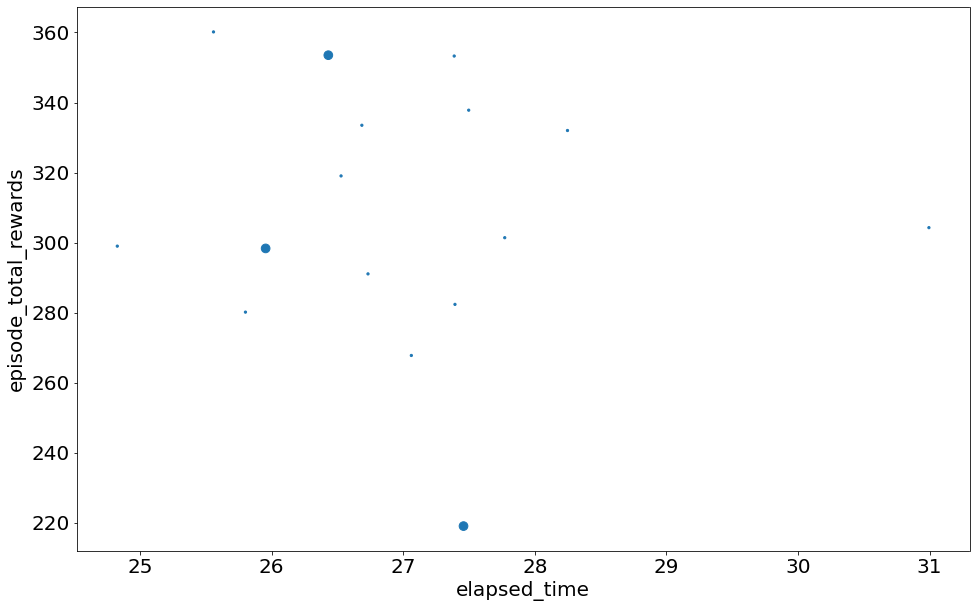

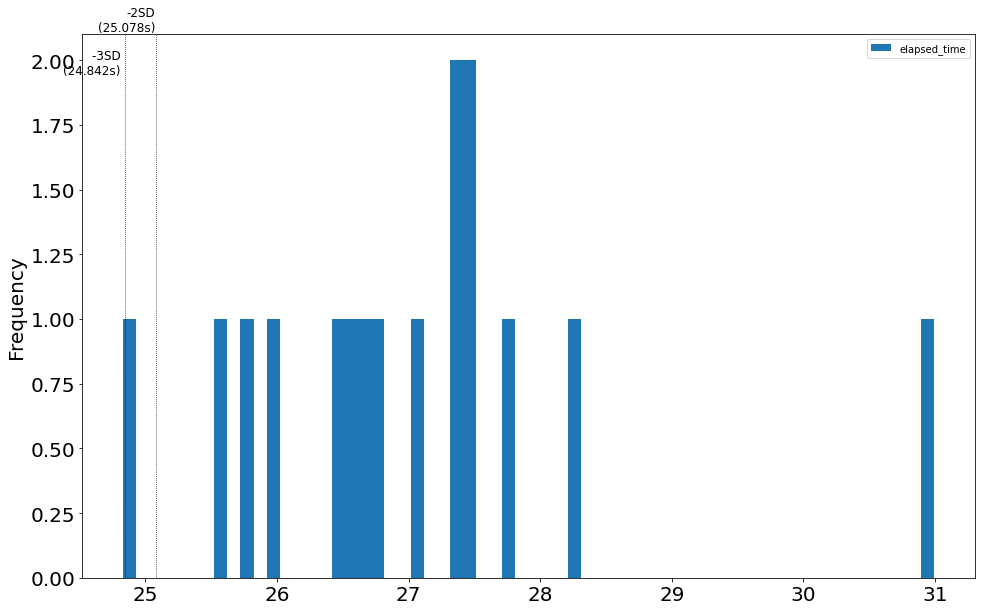

In [25]:
df_slice = sim_df_episodes[sim_df_episodes['status'] == 'lap_complete']
#df_slice = df_slice[df_slice['iteration'] <= 56]
max_iteration = df_slice['iteration'].max()

scatter_size = list()
for iter in df_slice['iteration']:
        if (iter > (max_iteration - 3)):
            scatter_size.append(75)
        else:
            scatter_size.append(5)
    
completed_episode_count = df_slice['episode'].count()
print('Completed Episodes: %d' % completed_episode_count)
if completed_episode_count > 0:
    axes = df_slice.plot(figsize=(16,10), fontsize=20, kind='scatter', s=scatter_size, x='elapsed_time', y='steps')
    axes.set_xlabel(axes.get_xlabel(), fontsize=20)
    axes.set_ylabel(axes.get_ylabel(), fontsize=20)
    
    axes = df_slice.plot(figsize=(16,10), fontsize=20, kind='scatter', s=scatter_size, x='elapsed_time', y='episode_total_rewards')
    axes.set_xlabel(axes.get_xlabel(), fontsize=20)
    axes.set_ylabel(axes.get_ylabel(), fontsize=20)
    
    w = 0.1
    n = math.ceil((df_slice['elapsed_time'].max() - df_slice['elapsed_time'].min())/w)
    if n == 0:
        n = 1
    print(n)
    axes = df_slice.plot(figsize=(16,10), fontsize=20, kind='hist', bins=n, x='steps', y='elapsed_time')
    axes.set_xlabel(axes.get_xlabel(), fontsize=20)
    axes.set_ylabel(axes.get_ylabel(), fontsize=20)
    
    data_minus2sd = np.percentile(df_slice['elapsed_time'], 2.28)
    data_minus3sd = np.percentile(df_slice['elapsed_time'], 0.13)

    print('Mean: %f' % (np.mean(df_slice['elapsed_time'])))
    print('Variance: %f' % (np.var(df_slice['elapsed_time'])))
    print('StdDev: %f' % (np.std(df_slice['elapsed_time'])))
    print('-2 StdDev: %f' % (data_minus2sd))
    print('-3 StdDev: %f' % (data_minus3sd))
    
    axes.axvline(x=data_minus2sd,linestyle='dotted',linewidth=0.75,color='black')
    axes.text(data_minus2sd, axes.get_ylim()[1], '-2SD\n(%0.3fs)' % data_minus2sd, ha='right', va='bottom', size=12)

    axes.axvline(x=data_minus3sd,linestyle='dotted',linewidth=0.75,color='black')
    axes.text(data_minus3sd, axes.get_ylim()[1], '\n-3SD \n(%0.3fs) ' % data_minus3sd, ha='right', va='top', size=12)


# Identify Potential Model Checkpoints for Cloning and Race Submission
- Plot the top quartile (p25) lap times vs iterations to identify potential model checkpoints and to look out for trade-offs between speed and stability over time
- Use the mean lap times per iteration among the p25 population to see through the noise
- Find the best lap times among the p25 population as an additional consideration

Completed Episodes: 16
p25: 26.312s
Completed Episodes (p25): 4


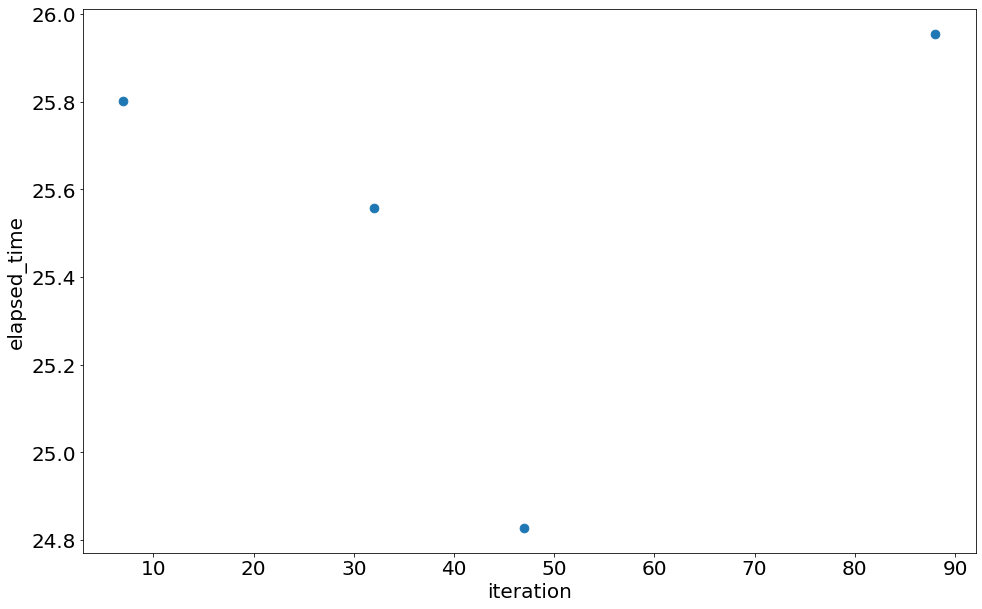

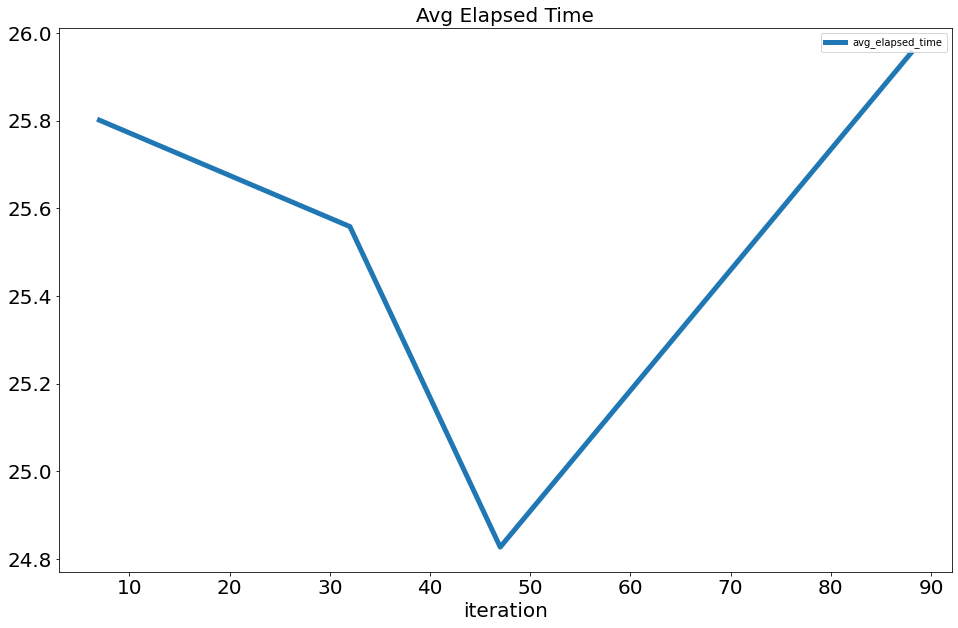

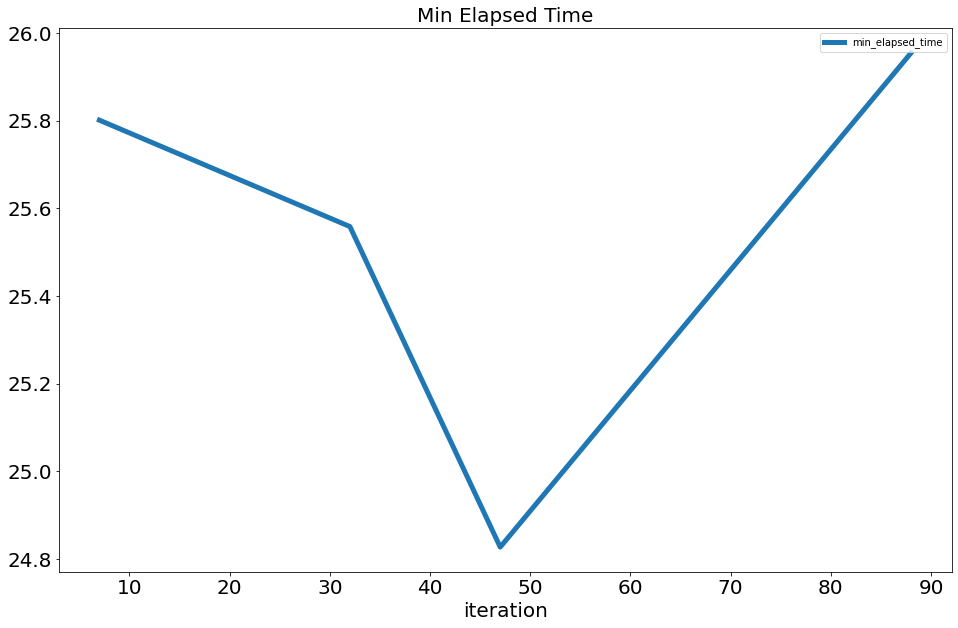

In [26]:
df_slice = sim_df_episodes[sim_df_episodes['status'] == 'lap_complete']
completed_episode_count = df_slice['episode'].count()
print('Completed Episodes: %d' % completed_episode_count)
if completed_episode_count > 0:
    elapsed_time_p25 = df_slice['elapsed_time'].quantile(.25)
    print('p25: %.3fs' % elapsed_time_p25)

    df_slice = df_slice[df_slice['elapsed_time'] <= elapsed_time_p25]
    completed_episode_p25_count = df_slice['episode'].count()
    print('Completed Episodes (p25): %d' % completed_episode_p25_count)
    if completed_episode_p25_count > 0:
        axes = df_slice.plot(figsize=(16,10), fontsize=20, kind='scatter', s=75, x='iteration', y='elapsed_time')
        axes.set_xlabel(axes.get_xlabel(), fontsize=20)
        axes.set_ylabel(axes.get_ylabel(), fontsize=20)
        
        df_slice["avg_elapsed_time"] = df_slice.groupby("iteration")["elapsed_time"].transform("mean")
        df_slice["min_elapsed_time"] = df_slice.groupby("iteration")["elapsed_time"].transform("min")

        axes = df_slice.plot(figsize=(16,10), fontsize=20, kind='line', linewidth=5, x='iteration', y='avg_elapsed_time')
        axes.set_xlabel(axes.get_xlabel(), fontsize=20)
        axes.set_ylabel(axes.get_ylabel(), fontsize=20)
        axes.set_title('Avg Elapsed Time', fontsize=20)
        
        axes = df_slice.plot(figsize=(16,10), fontsize=20, kind='line', linewidth=5, x='iteration', y='min_elapsed_time')
        axes.set_xlabel(axes.get_xlabel(), fontsize=20)
        axes.set_ylabel(axes.get_ylabel(), fontsize=20)
        axes.set_title('Min Elapsed Time', fontsize=20)

# Plot (Rewards vs Entropy vs Lap Progress) per Iteration

In [27]:
def plot_reward_graph(df_slice_iterations=sim_df_iterations, df_slice_entropy=trn_df_entropy):
    font_size=16
    if(len(df_slice_iterations)>0):
        fig = plt.figure(figsize=(16, 10))
        ax = plt.gca()  # gca stands for 'get current axis'
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # force integer labels on x-axis
        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

        df_slice_entropy.plot(kind='line',x='iteration',y='avg_entropy',label='',linewidth=1,color='red',alpha=0.3,fontsize=font_size,ax=ax)
        df_slice_entropy.plot(kind='line',linestyle='solid',x='iteration',y='avg_entropy_SMA3',linewidth=1.5,color='red',fontsize=font_size,ax=ax)

        df_slice_iterations.plot(kind='line',x='iteration',y='total_rewards_normalized',label='',linewidth=1,color='green',alpha=0.3,fontsize=font_size,ax=ax2)
        df_slice_iterations.plot(kind='line',linestyle='solid',x='iteration',y='total_rewards_normalized_SMA3',linewidth=1.5,color='green',fontsize=font_size,ax=ax2)

        df_slice_iterations.plot(kind='line',x='iteration',y='avg_progress',label='',linewidth=1,color='blue',alpha=0.3,fontsize=font_size,ax=ax2)
        df_slice_iterations.plot(kind='line',linestyle='dashdot',x='iteration',y='avg_progress_SMA3',linewidth=3,color='blue',fontsize=font_size,ax=ax2)

        ax.legend().remove()
        ax.set_xlabel(ax.get_xlabel(), fontsize=font_size)
        ax.set_ylabel('Entropy', fontsize=font_size)

        ax2.legend().remove()
        ax2.set_ylabel('Normalized Rewards / Progress (%) / Completed Laps (%)', fontsize=font_size)

        start_time = df_slice_iterations["start_time"].min()
        end_time = df_slice_iterations["end_time"].max()
        elapsed_time = end_time - start_time
        elapsed_time_hrs = elapsed_time / 3600
        plt.plot([], [], ' ', label='Iterations: %d' % df_slice_iterations["iteration"].max())
        plt.plot([], [], ' ', label='Elapsed Time: %0.2fhrs' % elapsed_time_hrs)

        fig.legend(loc="lower center", borderaxespad=0.1, ncol=4, fontsize=14, title="Legend")
        plt.subplots_adjust(bottom=0.15)

        max_rewards_iter = df_slice_iterations['total_rewards_normalized_SMA3'].idxmax()
        if (max_rewards_iter >= 0):
            xmax_rewards = df_slice_iterations['iteration'][max_rewards_iter]
            ymax_rewards = df_slice_iterations['total_rewards_normalized_SMA3'].max()
            plt.axvline(x=xmax_rewards,linestyle='dotted',linewidth=0.75,color='black')
            plt.axhline(y=ymax_rewards,linestyle='dotted',linewidth=0.75,color='black',alpha=0.3)
            plt.gca().text(xmax_rewards*0.995, ymax_rewards*1.005, 'Max Rewards @ %d' % xmax_rewards, ha='right', va='bottom', size=font_size)

        max_progress_iter = df_slice_iterations['avg_progress_SMA3'].idxmax()
        if (max_progress_iter >= 0):
            xmax_progress = df_slice_iterations['iteration'][max_progress_iter]
            ymax_progress = df_slice_iterations['avg_progress_SMA3'].max()
            plt.axvline(x=xmax_progress,linestyle='dotted',linewidth=0.75,color='black')
            plt.axhline(y=ymax_progress,linestyle='dotted',linewidth=0.75,color='black',alpha=0.3)
            plt.gca().text(xmax_progress*0.995, ymax_progress*1.005, 'Max Progress @ %d' % xmax_progress, ha='right', va='bottom', size=font_size)

        plt.yticks(np.arange(0, 105, step=10))
        plt.show()
        if (max_rewards_iter >= 0):
            print ("Iteration with Max Total Rewards (SMA3): %d" % (xmax_rewards))
        print ("Elapsed Time: %0.2fs (%0.2fhrs)" % (elapsed_time, elapsed_time_hrs))

# Plot Entropy vs Rewards/Progress as an Additional Indicator for Convergence
- Uses the SMA3 aggregate data to smoothen the graph plot

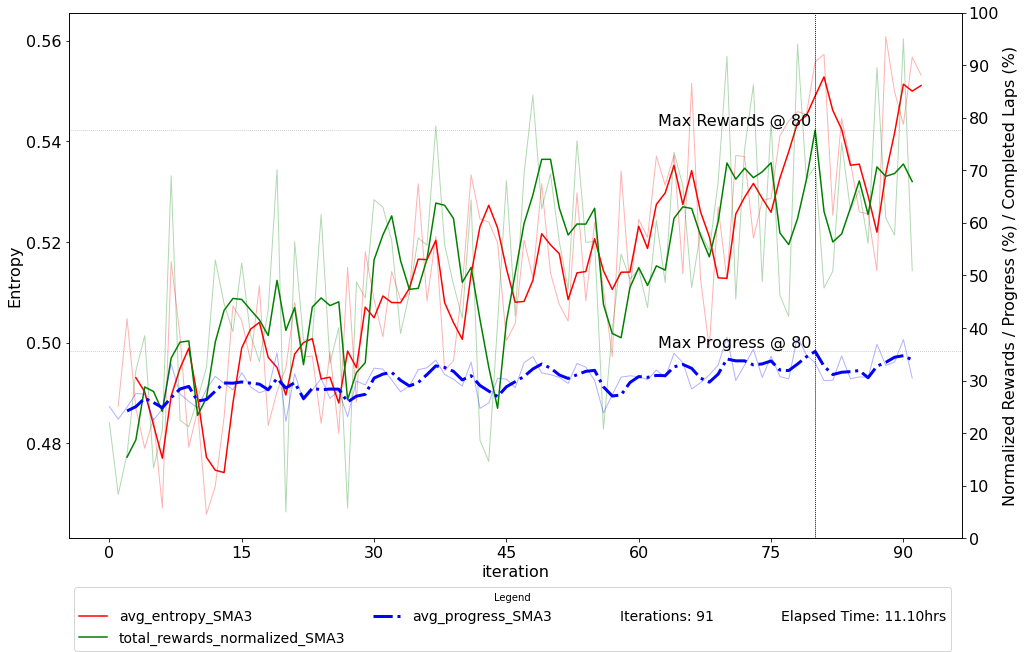

Iteration with Max Total Rewards (SMA3): 80
Elapsed Time: 39976.01s (11.10hrs)


In [28]:
plot_reward_graph()

# Plot the Lap-Completion Ratio of Episodes in Each Iteration to Gauge the Consistency of the Model
- Uses the SMA3 aggregate data to smoothen the graph plot

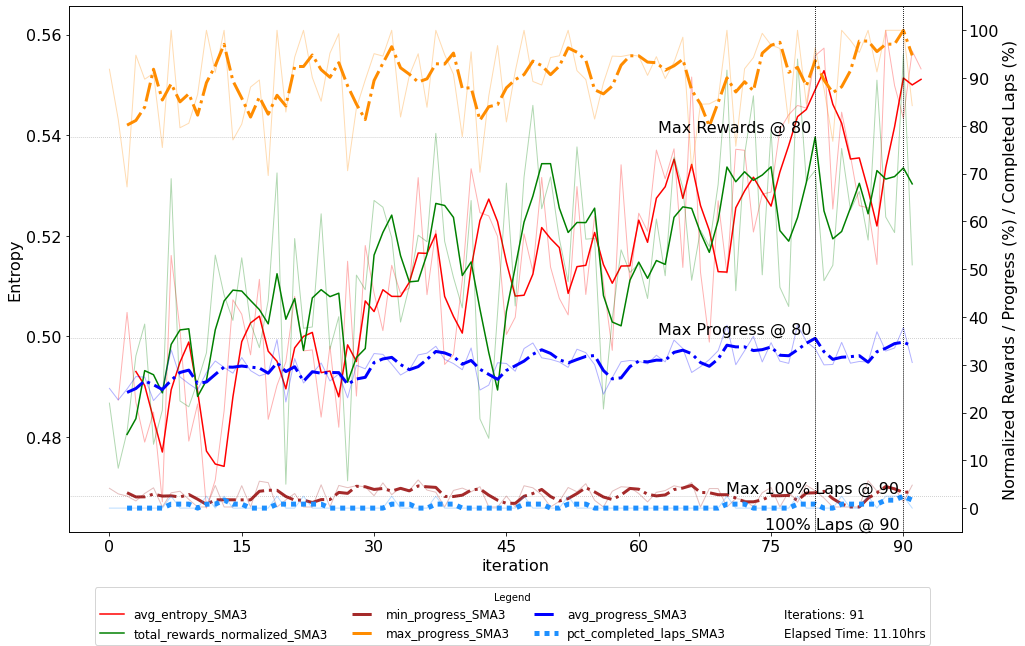

Iteration with First Completed Laps (SMA3): 90
Iteration with Max Pct Completed Laps (SMA3): 90 (Value 2.5)
Iteration with Max Total Rewards (SMA3): 80
Elapsed Time: 39976.01s (11.10hrs)


In [29]:
font_size=16
if(len(sim_df_iterations)>0):
    fig = plt.figure(figsize=(16, 10))
    ax = plt.gca()  # gca stands for 'get current axis'
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # force integer labels on x-axis
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    trn_df_entropy.plot(kind='line',x='iteration',y='avg_entropy',label='',linewidth=1,color='red',alpha=0.3,fontsize=font_size,ax=ax)
    trn_df_entropy.plot(kind='line',linestyle='solid',x='iteration',y='avg_entropy_SMA3',linewidth=1.5,color='red',fontsize=font_size,ax=ax)

    sim_df_iterations.plot(kind='line',x='iteration',y='total_rewards_normalized',label='',linewidth=1,color='green',alpha=0.3,fontsize=font_size,ax=ax2)
    sim_df_iterations.plot(kind='line',linestyle='solid',x='iteration',y='total_rewards_normalized_SMA3',linewidth=1.5,color='green',fontsize=font_size,ax=ax2)

    sim_df_iterations.plot(kind='line',x='iteration',y='min_progress',label='',linewidth=1,color='brown',alpha=0.3,fontsize=font_size,ax=ax2)
    sim_df_iterations.plot(kind='line',linestyle='dashdot',x='iteration',y='min_progress_SMA3',linewidth=3,color='brown',fontsize=font_size,ax=ax2)

    sim_df_iterations.plot(kind='line',x='iteration',y='max_progress',label='',linewidth=1,color='darkorange',alpha=0.3,fontsize=font_size,ax=ax2)
    sim_df_iterations.plot(kind='line',linestyle='dashdot',x='iteration',y='max_progress_SMA3',linewidth=3,color='darkorange',fontsize=font_size,ax=ax2)

    sim_df_iterations.plot(kind='line',x='iteration',y='avg_progress',label='',linewidth=1,color='blue',alpha=0.3,fontsize=font_size,ax=ax2)
    sim_df_iterations.plot(kind='line',linestyle='dashdot',x='iteration',y='avg_progress_SMA3',linewidth=3,color='blue',fontsize=font_size,ax=ax2)

    sim_df_iterations.plot(kind='line',x='iteration',y='pct_completed_laps',label='',linewidth=1,color='dodgerblue',alpha=0.3,fontsize=font_size,ax=ax2)
    sim_df_iterations.plot(kind='line',linestyle=(0,(1,1)),x='iteration',y='pct_completed_laps_SMA3',linewidth=5,color='dodgerblue',fontsize=font_size,ax=ax2)

    ax.legend().remove()
    ax.set_xlabel(ax.get_xlabel(), fontsize=font_size)
    ax.set_ylabel('Entropy', fontsize=font_size)
    ax2.legend().remove()
    ax2.set_ylabel('Normalized Rewards / Progress (%) / Completed Laps (%)', fontsize=font_size)

    start_time = sim_df_iterations["start_time"].min()
    end_time = sim_df_iterations["end_time"].max()
    elapsed_time = end_time - start_time
    elapsed_time_hrs = elapsed_time / 3600
    plt.plot([], [], ' ', label='Iterations: %d' % sim_df_iterations["iteration"].max())
    plt.plot([], [], ' ', label='Elapsed Time: %0.2fhrs' % elapsed_time_hrs)

    fig.legend(loc="lower center", borderaxespad=0.1, ncol=4, fontsize=12, title="Legend")
    plt.subplots_adjust(bottom=0.15)

    first_100pct_iteration = sim_df_iterations[sim_df_iterations["max_progress_SMA3"] >= 100.0]['iteration'].min()
    if first_100pct_iteration > 0:
        plt.axvline(x=first_100pct_iteration,linestyle='dotted',linewidth=0.75,color='black')
        plt.gca().text(first_100pct_iteration*0.995, ax2.get_ylim()[0], '100%% Laps @ %d' % first_100pct_iteration, ha='right', va='bottom', size=font_size)

    max_rewards_iter = sim_df_iterations['total_rewards_normalized_SMA3'].idxmax()
    if (max_rewards_iter >= 0):
        xmax_rewards = sim_df_iterations['iteration'][sim_df_iterations['total_rewards_normalized_SMA3'].idxmax()]
        ymax_rewards = sim_df_iterations['total_rewards_normalized_SMA3'].max()
        plt.axvline(x=xmax_rewards,linestyle='dotted',linewidth=0.75,color='black')
        plt.axhline(y=ymax_rewards,linestyle='dotted',linewidth=0.75,color='black',alpha=0.3)
        plt.gca().text(xmax_rewards*0.995, ymax_rewards*1.005, 'Max Rewards @ %d' % xmax_rewards, ha='right', va='bottom', size=font_size)

    max_progress_iter = sim_df_iterations['avg_progress_SMA3'].idxmax()
    if (max_progress_iter >= 0):
        xmax_progress = sim_df_iterations['iteration'][sim_df_iterations['avg_progress_SMA3'].idxmax()]
        ymax_progress = sim_df_iterations['avg_progress_SMA3'].max()
        plt.axvline(x=xmax_progress,linestyle='dotted',linewidth=0.75,color='black')
        plt.axhline(y=ymax_progress,linestyle='dotted',linewidth=0.75,color='black',alpha=0.3)
        plt.gca().text(xmax_progress*0.995, ymax_progress*1.005, 'Max Progress @ %d' % xmax_progress, ha='right', va='bottom', size=font_size)

    max_completed_iter = sim_df_iterations['pct_completed_laps_SMA3'].idxmax()
    if (max_completed_iter >= 0):
        xmax_completed_laps = sim_df_iterations['iteration'][sim_df_iterations['pct_completed_laps_SMA3'].idxmax()]
        ymax_completed_laps = sim_df_iterations['pct_completed_laps_SMA3'].max()
        plt.axvline(x=xmax_completed_laps,linestyle='dotted',linewidth=0.75,color='black')
        plt.axhline(y=ymax_completed_laps,linestyle='dotted',linewidth=0.75,color='black',alpha=0.3)
        plt.gca().text(xmax_completed_laps*0.995, ymax_completed_laps*1.005, 'Max 100%% Laps @ %d' % xmax_completed_laps, ha='right', va='bottom', size=font_size)
    
    plt.yticks(np.arange(0, 105, step=10))
    plt.show()

    if (first_100pct_iteration >= 0):
        text= "Iteration with First Completed Laps (SMA3): {:}".format(first_100pct_iteration)
        print(text)

    if (max_completed_iter >= 0):
        text= "Iteration with Max Pct Completed Laps (SMA3): {:} (Value {:})".format(xmax_completed_laps, ymax_completed_laps)
        print(text)

    if (max_rewards_iter >= 0):
        text= "Iteration with Max Total Rewards (SMA3): {:}".format(xmax_rewards)
        print(text)

    print ("Elapsed Time: %0.2fs (%0.2fhrs)" % (elapsed_time, elapsed_time_hrs))


# Load & Visualise the Track Waypoints

If the track is not found, download newer tracks from the [deepracer-simapp bundle](https://github.com/aws-deepracer-community/deepracer-simapp/tree/master/bundle/deepracer_simulation_environment/share/deepracer_simulation_environment/routes) maintained by the community, and copy them into the `tracks` folder

In [30]:
# List the available tracks vs expected WORLD_NAME
print('WORLD_NAME: %s' % WORLD_NAME)
ListFiles = [f for f in listdir("tracks/") if isfile(join("tracks/", f))]
ListFiles
print('Available Tracks: %s' % ListFiles)

WORLD_NAME: Austin
Available Tracks: ['AWS_track.npy', 'Albert.npy', 'AmericasGeneratedInclStart.npy', 'Aragon.npy', 'Austin.npy', 'Belille.npy', 'Bowtie_track.npy', 'Canada_Eval.npy', 'Canada_Training.npy', 'ChampionshipCup2019_track.npy', 'China_eval_track.npy', 'China_track.npy', 'FS_June2020.npy', 'H_track.npy', 'July_2020.npy', 'LGSWide.npy', 'London_Loop_Train.npy', 'Mexico_track.npy', 'Mexico_track_eval.npy', 'Monaco.npy', 'New_York_Eval_Track.npy', 'New_York_Track.npy', 'Oval_track.npy', 'Singapore.npy', 'Spain_track.npy', 'Straight_track.npy', 'Tokyo_Training_track.npy', 'Vegas_track.npy', 'Virtual_May19_Train_track.npy', 'reInvent2019_track.npy', 'reInvent2019_wide.npy', 'reInvent2019_wide_mirrored.npy', 'reinvent_base.npy']


In [31]:
fpath = "./racelines/Austin-1500-4-2020-11-26-203913.npy"

racing_track = np.load(fpath)

# Convert np array to list and remove last point because it is the same point as the first one
#racing_track = racing_track.tolist()[:]

In [32]:
def get_track_waypoints(track_name):
    return np.load("tracks/%s.npy" % track_name)
    
waypoints = get_track_waypoints(WORLD_NAME)
waypoints.shape

(224, 6)

In [33]:
def plot_points(ax, points):
    ax.scatter(points[:-1,0], points[:-1,1], s=1)
    for i,p in enumerate(points):
        if i % 5 == 0:
            ax.annotate(i, (p[0], p[1]))
        #else:
            #ax.annotate('*', (p[0], p[1]), color=color)

def plot_line(ax, ob, color):
    ob = LineString(ob)                                                
    x, y = ob.xy                                                                
    ax.plot(x, y, color=color, alpha=0.5, linewidth=3, solid_capstyle='round', zorder=2)


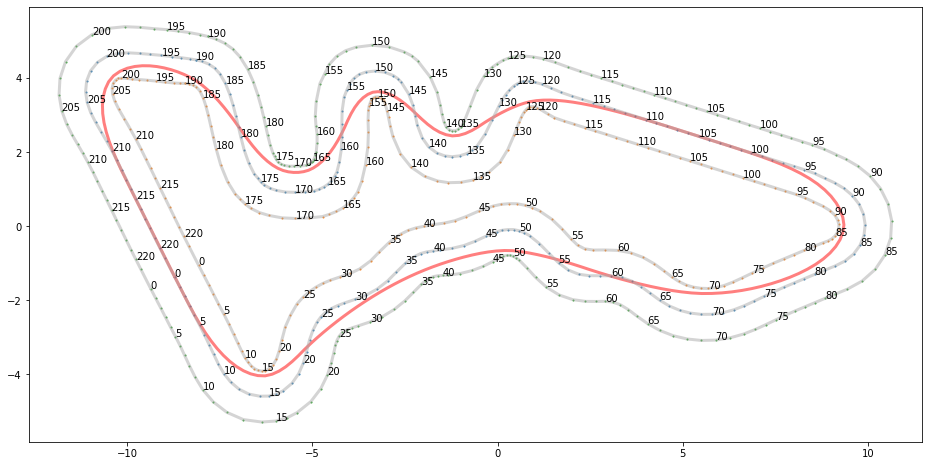

In [34]:
# Plot the results
fig, ax = plt.subplots(figsize=(16,8))


plot_line(ax, racing_track, 'red' )
plot_line(ax, waypoints[:,0:2], '#aaaaaa')
plot_line(ax, waypoints[:,2:4], '#aaaaaa')
plot_line(ax, waypoints[:,4:6], '#aaaaaa')

plot_points(ax, waypoints[:-1,0:2])
plot_points(ax, waypoints[:-1,2:4])
plot_points(ax, waypoints[:-1,4:6])
ax.axis('equal')
plt.show()

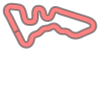

In [35]:
l_center_line = LineString(waypoints[:,0:2])
l_inner_border = LineString(waypoints[:,2:4])
l_outer_border = LineString(waypoints[:,4:6])
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))
road_poly

In [36]:
# rescale waypoints to centimeter scale
center_line = waypoints[:,0:2] *100
inner_border = waypoints[:,2:4] *100
outer_border = waypoints[:,4:6] *100
racing_track = racing_track[:] *100

In [37]:
# add x_offset to bring everything to the positive axis

x_offset = int(sim_df['x'].min())
if x_offset > 0: # if positive, just keep it the same
    x_offset = 0
x_offset = abs(x_offset)

inner_border[:,:] = inner_border[:,:] + x_offset
center_line[:,:] = center_line[:,:] + x_offset
outer_border[:,:] = outer_border[:,:] + x_offset

racing_track[:,:] = racing_track[:,:] + x_offset

In [38]:
# add y_offset to bring everything to the positive axis

y_offset = int(sim_df['y'].min())
if y_offset > 0: # if positive, just keep it the same
    y_offset = 0
y_offset = abs(y_offset)

inner_border[:,1] = inner_border[:,1] + y_offset - x_offset
center_line[:,1] = center_line[:,1] + y_offset - x_offset
outer_border[:,1] = outer_border[:,1] + y_offset - x_offset

In [39]:
# track dimensions
track_x_max = outer_border[:,:].max()
track_y_max = outer_border[:,1].max()
print ('Track Dimensions: (%f, %f)' % (track_x_max, track_y_max))

# simulation dimensions
sim_x_max = sim_df['x'].max() + x_offset
sim_y_max = sim_df['y'].max() + y_offset
print ('Simulation Dimensions: (%f, %f)' % (sim_x_max, sim_y_max))

# plot dimensions
plot_x_max = int(math.ceil(max(track_x_max, sim_x_max)/50) * 50)
plot_y_max = int(math.ceil(max(track_y_max, sim_y_max)/50) * 50)
print ('Plot Dimensions: (%d, %d)' % (plot_x_max, plot_y_max))

Track Dimensions: (2271.776970, 1092.030504)
Simulation Dimensions: (2289.950000, 1120.040000)
Plot Dimensions: (2300, 1150)


In [40]:
def plot_coords(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, '.', color='#999999', zorder=1)

def plot_line(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, color='cyan', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

def print_border(ax, waypoints, inner_border_waypoints, outer_border_waypoints):
    line = LineString(waypoints)
    plot_coords(ax, line)
    plot_line(ax, line)

    line = LineString(inner_border_waypoints)
    plot_coords(ax, line)
    plot_line(ax, line)

    line = LineString(outer_border_waypoints)
    plot_coords(ax, line)
    plot_line(ax, line)

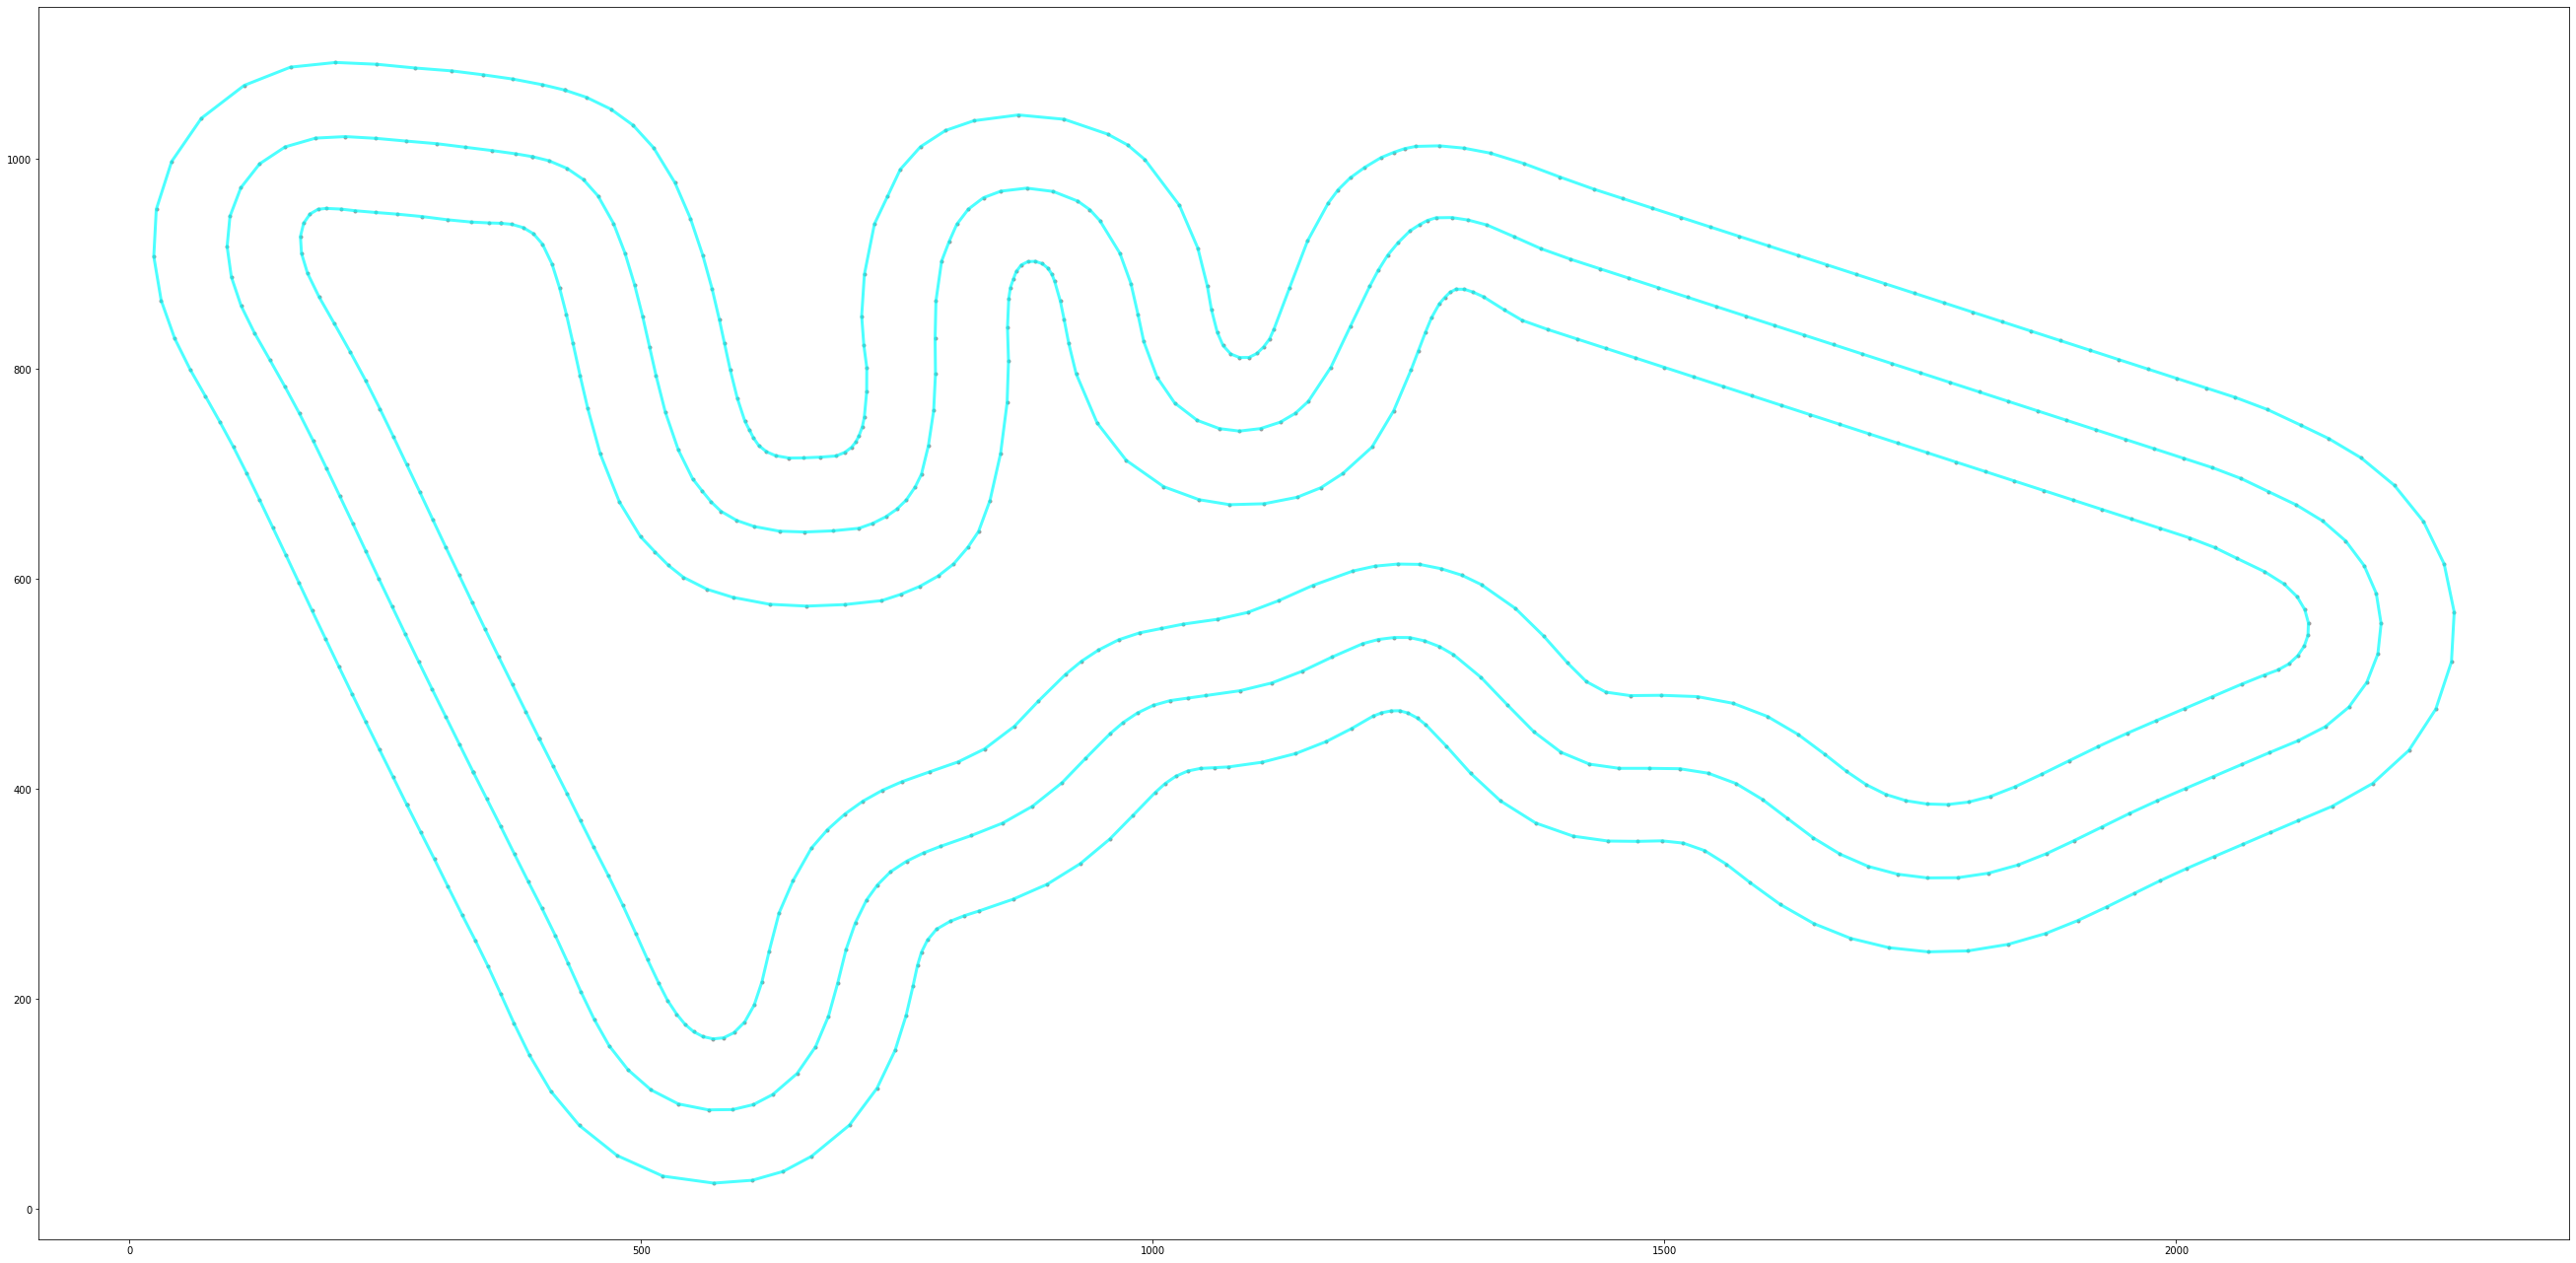

In [41]:
# Plot the track layout with the right scale and size

fig = plt.figure(figsize=(plot_x_max/50, plot_y_max/50))
ax = fig.add_subplot(111)
print_border(ax, center_line, inner_border, outer_border)

# Plot Actions Utilisation Heatmap for the Most Recent Iteration to Tweak the Action Space
- Use a heatmap to visualise the relative use of each action in the action space, in order to identify actions to consolidate / remove

In [42]:
def plot_count_on_action(df):
    actionspace = np.zeros((int((action_max_speed+(action_min_speed/3)) * 10 * 1.1), int(action_steering_range * 1.1)))
    for index, row in df.iterrows():
        x = int(row["steer"])+(int(action_steering_range * 1.1 / 2))
        y = int(row["throttle"]*10)
        actionspace[y,x] += 1
        
    fig = plt.figure(1, figsize=(16,10))
    ax = fig.add_subplot(111)
    return actionspace

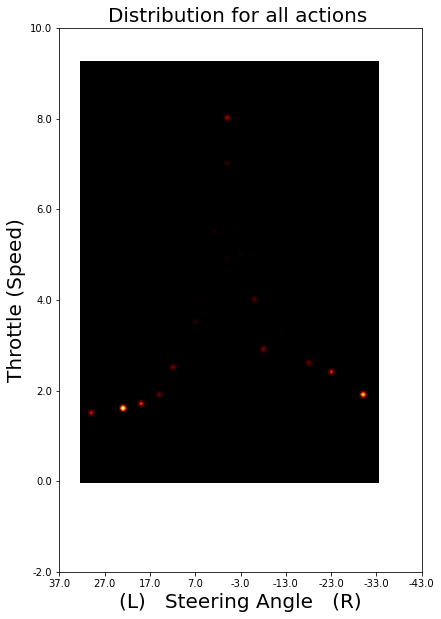

In [43]:
max_iteration = sim_df['iteration'].max()
df_slice = sim_df[sim_df['iteration'] == max_iteration]

track = plot_count_on_action(df_slice)
plt.title("Distribution for all actions ", fontsize=20)
im = plt.imshow(track, cmap='afmhot', interpolation='bilinear', origin="lower") 

ax = plt.gca()  # gca stands for 'get current axis'
ax.set_xlabel('(L)   Steering Angle   (R)', fontsize=20)
ax.set_ylabel('Throttle (Speed)', fontsize=20)

xlabels = ax.get_xticks()
ax.set_xticks(xlabels)
new_xlabels = [(x-int(action_steering_range * 1.1 / 2)) for x in xlabels]
ax.xaxis.set_ticklabels(new_xlabels)
ax.set_xlim(xlabels[-1], xlabels[0])

ylabels = ax.get_yticks()
ax.set_yticks(ylabels)
new_ylabels = [(y/10) for y in ylabels]    
ax.yaxis.set_ticklabels(new_ylabels)

plt.show()

# Plot Avg Speed and Steering at Each Waypoint (Horizontal) for the Most Recent Iteration
- Visualise the Avg Speed and Steering Angle at each waypoint (horizontally), to identify inefficiencies in driving behaviour

In [44]:
def plot_speedsteering_per_waypoint_h(df):
    max_waypoint = df['closest_waypoint'].max()
    print ('max_waypoint: %d' % max_waypoint)
    
    max_steering = max(abs(df['steer'].min()), abs(df['steer'].max()))
    max_speed = df['throttle'].max()
    fig = plt.figure(figsize=(25.6, 16))
    
    plt.xticks(np.arange(0, max_waypoint+1, 10.0), fontsize=20)
    plt.xlabel('\nWaypoint', fontsize=20)
    plt.yticks(np.arange(math.floor(-max_steering), math.ceil(max_steering)+1, 5.0), fontsize=20)
    plt.ylabel('(L)   Steering Angle   (R)\n\n\n', fontsize=20, rotation=270)
    
    ax = plt.gca()  # gca stands for 'get current axis'
    ax.set_xticks(np.arange(5, max_waypoint+1, 10.0), minor=True)
    ax.tick_params(axis='x', which='major', length=10, direction='inout')
    ax.tick_params(axis='x', which='minor', length=5, direction='in')
    ax.set_ylim(math.floor(-max_steering), math.ceil(max_steering))
    ax.set_yticks(np.arange(math.floor(-max_steering)+1, math.ceil(max_steering)+1, 1.0), minor=True)
    ax.tick_params(axis='y', which='major', length=10, direction='inout')
    ax.tick_params(axis='y', which='minor', length=5, direction='in')


    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('\n\n\nThrottle', fontsize=20, rotation=270)
    ax2.set_ylim(-max_speed, max_speed)
    ax2.set_yticks(np.arange(0, max_speed+0.5, 0.5))
    ax2.set_yticks(np.arange(0.1, max_speed+0.1, 0.1), minor=True)
    ax2.tick_params(axis='y', which='major', length=10, direction='inout', labelsize=20)
    ax2.tick_params(axis='y', which='minor', length=5, direction='in')

    wp_steering = list(range(max_waypoint + 1))
    wp_steering_count = list(range(max_waypoint + 1))
    wp_speed = list(range(max_waypoint + 1))
    wp_speed_count = list(range(max_waypoint + 1))
    
    for wp in range(0, max_waypoint+1):
        wp_steering[wp] = 0
        wp_steering_count[wp] = 0
        wp_speed[wp] = 0
        wp_speed_count[wp] = 0

    for index, row in df.iterrows():
        closest_waypoint = row['closest_waypoint']
        steering_angle = row['steer']
        wp_steering[closest_waypoint] += steering_angle
        wp_steering_count[closest_waypoint] += 1
        speed = row['throttle']
        wp_speed[closest_waypoint] += (speed)
        wp_speed_count[closest_waypoint] += 1
        
    for wp in range(0, max_waypoint+1):
        if (wp_steering_count[wp]>0):
            avg_steering_angle = wp_steering[wp] / wp_steering_count[wp]
            x = [wp, wp]
            y = [0, avg_steering_angle]
            ax.plot(x, y, marker = 'o', color='blue', alpha=0.5, linewidth=3)
        else:
            ax.plot([wp, wp], [0, 0], marker = 'o', color='blue', alpha=0.5, linewidth=3)
        if (wp_speed_count[wp]>0):
            avg_speed = wp_speed[wp] / wp_speed_count[wp]
            x = [wp, wp]
            y = [-avg_speed, avg_speed]
            ax2.plot(x, y, marker = 'x', color='red', alpha=0.5, linewidth=1)
        else:
            ax2.plot([wp, wp], [0, 0], marker = 'x', color='red', alpha=0.5, linewidth=1)




max_waypoint: 222


iteration  episode_in_iteration  episode  steps        x       y  \
466355         92                    17     3697      1  -693.85  242.78   
466356         92                    17     3697      2  -693.87  242.84   
466357         92                    17     3697      3  -694.22  243.87   
466358         92                    17     3697      4  -694.84  245.87   
466359         92                    17     3697      5  -695.90  249.39   
466360         92                    17     3697      6  -697.66  254.70   
466361         92                    17     3697      7  -699.90  260.96   
466362         92                    17     3697      8  -702.54  268.14   
466363         92                    17     3697      9  -705.60  275.95   
466364         92                    17     3697     10  -710.40  287.92   
466365         92                    17     3697     11  -715.97  300.41   
466366         92                    17     3697     12  -721.30  310.79   
466367         92                    17     3697     13  -729.44  323.66   
466368         92                    17     3697     14  -738.29  335.78   
466369         92                    17     3697     15  -746.85  345.18   
466370         92                    17     3697     16  -762.81  359.76   
466371         92                    17     3697     17  -773.85  367.75   
466372         92                    17     3697     18  -784.21  374.40   
466373         92                    17     3697     19  -797.06  381.52   
466374         92                    17     3697     20  -808.88  387.31   
466375         92                    17     3697     21  -825.82  395.36   
466376         92                    17     3697     22  -838.78  402.02   
466377         92                    17     3697     23  -851.43  409.49   
466378         92                    17     3697     24  -863.85  417.91   
466379         92                    17     3697     25  -878.12  429.00   
466380         92                    17     3697     26  -888.98  437.29   
466381         92                    17     3697     27  -903.17  447.15   
466382         92                    17     3697     28  -914.54  453.44   
466383         92                    17     3697     29  -922.99  457.30   
466384         92                    17     3697     30  -934.57  461.78   
466385         92                    17     3697     31  -949.02  466.26   
466386         92                    17     3697     32  -961.59  468.99   
466387         92                    17     3697     33  -973.63  471.22   
466388         92                    17     3697     34  -985.62  472.16   
466389         92                    17     3697     35  -999.94  471.70   
466390         92                    17     3697     36 -1003.69  471.28   
466391         92                    17     3697     37 -1021.77  466.96   
466392         92                    17     3697     38 -1031.46  463.50   
466393         92                    17     3697     39 -1040.78  459.22   
466394         92                    17     3697     40 -1054.69  450.97   
466395         92                    17     3697     41 -1062.24  445.52   
466396         92                    17     3697     42 -1066.89  441.82   
466397         92                    17     3697     43 -1074.62  434.66   
466398         92                    17     3697     44 -1084.41  423.69   
466399         92                    17     3697     45 -1090.51  413.67   
466400         92                    17     3697     46 -1092.81  409.25   
466401         92                    17     3697     47 -1100.32  391.17   
466402         92                    17     3697     48 -1102.39  384.02   
466403         92                    17     3697     49 -1104.51  374.74   
466404         92                    17     3697     50 -1106.36  363.07   
466405         92                    17     3697     51 -1106.74  348.36   
466406         92                    17     3697     52 

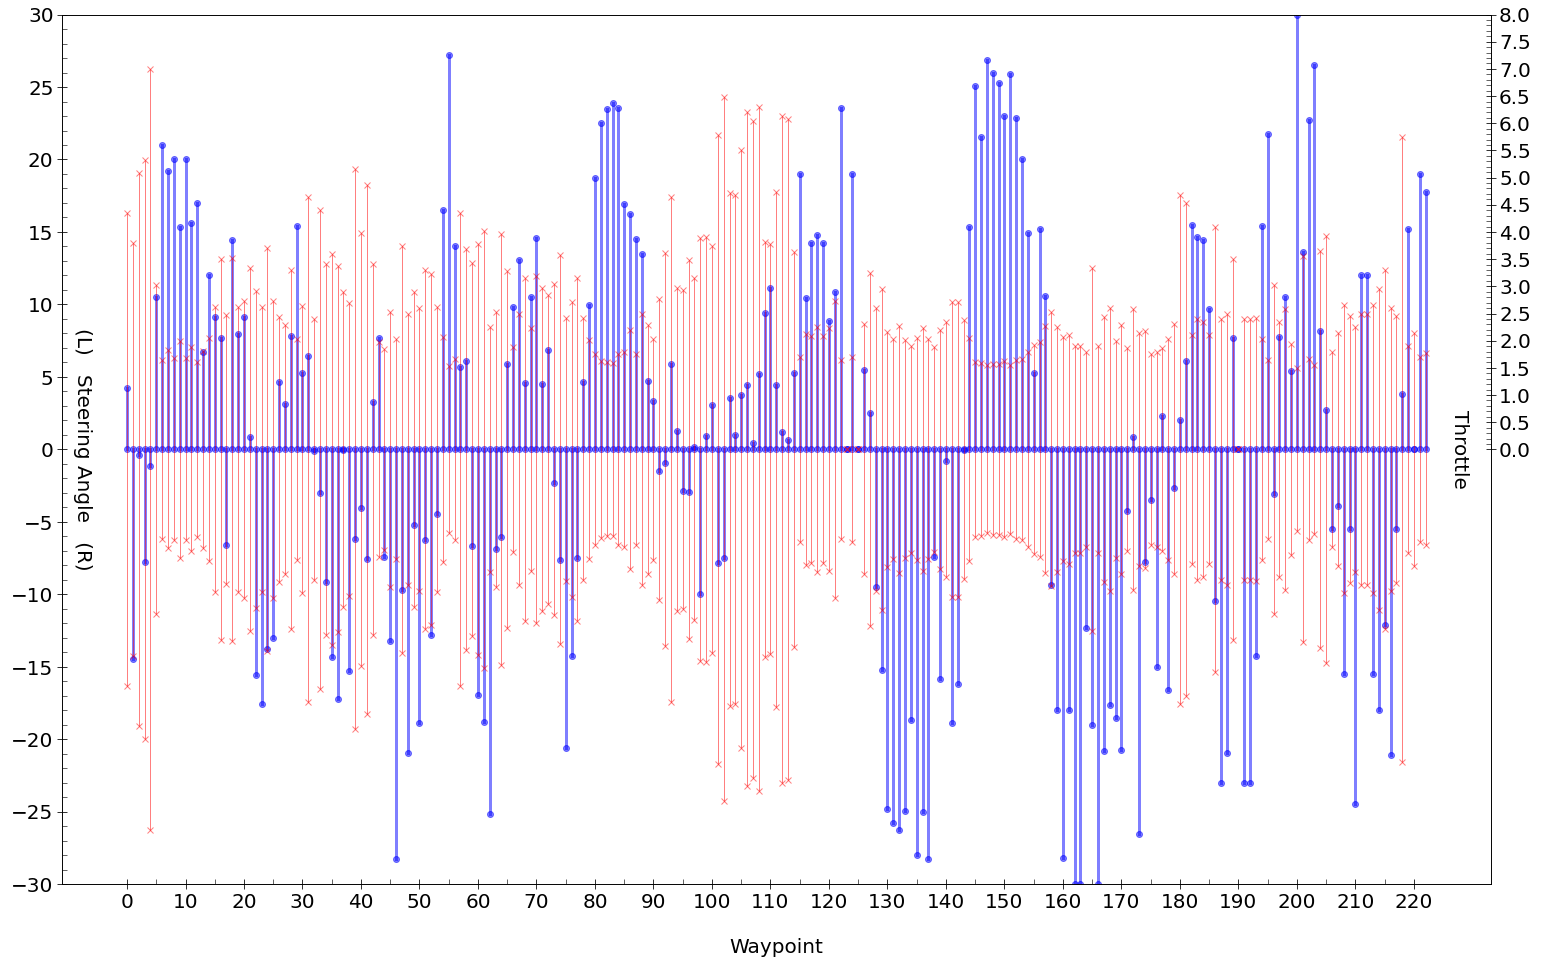

In [45]:
max_iteration = sim_df['iteration'].max()
max_episode = sim_df['episode'].max()
plot_speedsteering_per_waypoint_h(sim_df[sim_df['iteration']==max_iteration])
sim_df[sim_df['episode']==max_episode]
#plot_speedsteering_per_waypoint_h(sim_df[sim_df['episode']==21])
#sim_df[sim_df['episode']==21]

# Plot Avg Speed and Steering at Each Waypoint (Vertical) for the Most Recent Iteration
- Visualise the Avg Speed and Steering Angle at each waypoint (vertically), to identify inefficiencies in driving behaviour

In [46]:
def plot_speedsteering_per_waypoint_v(df):
    max_waypoint = df['closest_waypoint'].max()
    print ('max_waypoint: %d' % max_waypoint)
    
    max_steering = max(abs(df['steer'].min()), abs(df['steer'].max()))
    max_speed = df['throttle'].max()
    fig = plt.figure(figsize=(16, max_waypoint/10))
    
    plt.yticks(np.arange(0, max_waypoint+1, 5.0), fontsize=12)
    plt.ylabel('Waypoint\n', fontsize=20)
    plt.xticks(np.arange(math.floor(-max_steering), math.ceil(max_steering)+1, 5.0), fontsize=12)
    plt.xlabel('\n(L)   Steering Angle   (R)', fontsize=20)
    
    ax = plt.gca()  # gca stands for 'get current axis'
    ax.set_xlim(math.ceil(max_steering), math.floor(-max_steering))

    ax2 = ax.twiny()  # instantiate a second axes that shares the same x-axis
    ax2.set_xlabel('Throttle\n', fontsize=20)
    ax2.set_xlim(-max_speed, max_speed)
    ax2.set_xticks(np.arange(0, max_speed+0.5, 0.5))

    wp_steering = list(range(max_waypoint + 1))
    wp_steering_count = list(range(max_waypoint + 1))
    wp_speed = list(range(max_waypoint + 1))
    wp_speed_count = list(range(max_waypoint + 1))
    
    for wp in range(0, max_waypoint+1):
        wp_steering[wp] = 0
        wp_steering_count[wp] = 0
        wp_speed[wp] = 0
        wp_speed_count[wp] = 0

    for index, row in df.iterrows():
        closest_waypoint = row['closest_waypoint']
        steering_angle = row['steer']
        wp_steering[closest_waypoint] += steering_angle
        wp_steering_count[closest_waypoint] += 1
        speed = row['throttle']
        wp_speed[closest_waypoint] += (speed)
        wp_speed_count[closest_waypoint] += 1
        
    for wp in range(0, max_waypoint+1):
        if (wp_steering_count[wp]>0):
            avg_steering_angle = wp_steering[wp] / wp_steering_count[wp]
            x = [0, avg_steering_angle]
            y = [wp, wp]
            ax.plot(x, y, marker = 'o', color='blue', alpha=0.5, linewidth=3)
        else:
            ax.plot([0, 0], [wp, wp], marker = 'o', color='blue', alpha=0.5, linewidth=3)
        if (wp_speed_count[wp]>0):
            avg_speed = wp_speed[wp] / wp_speed_count[wp]
            x = [-avg_speed, avg_speed]
            y = [wp, wp]
            ax2.plot(x, y, marker = 'x', color='red', alpha=0.5, linewidth=1)
        else:
            ax2.plot([0, 0], [wp, wp], marker = 'x', color='red', alpha=0.5, linewidth=1)



max_waypoint: 222


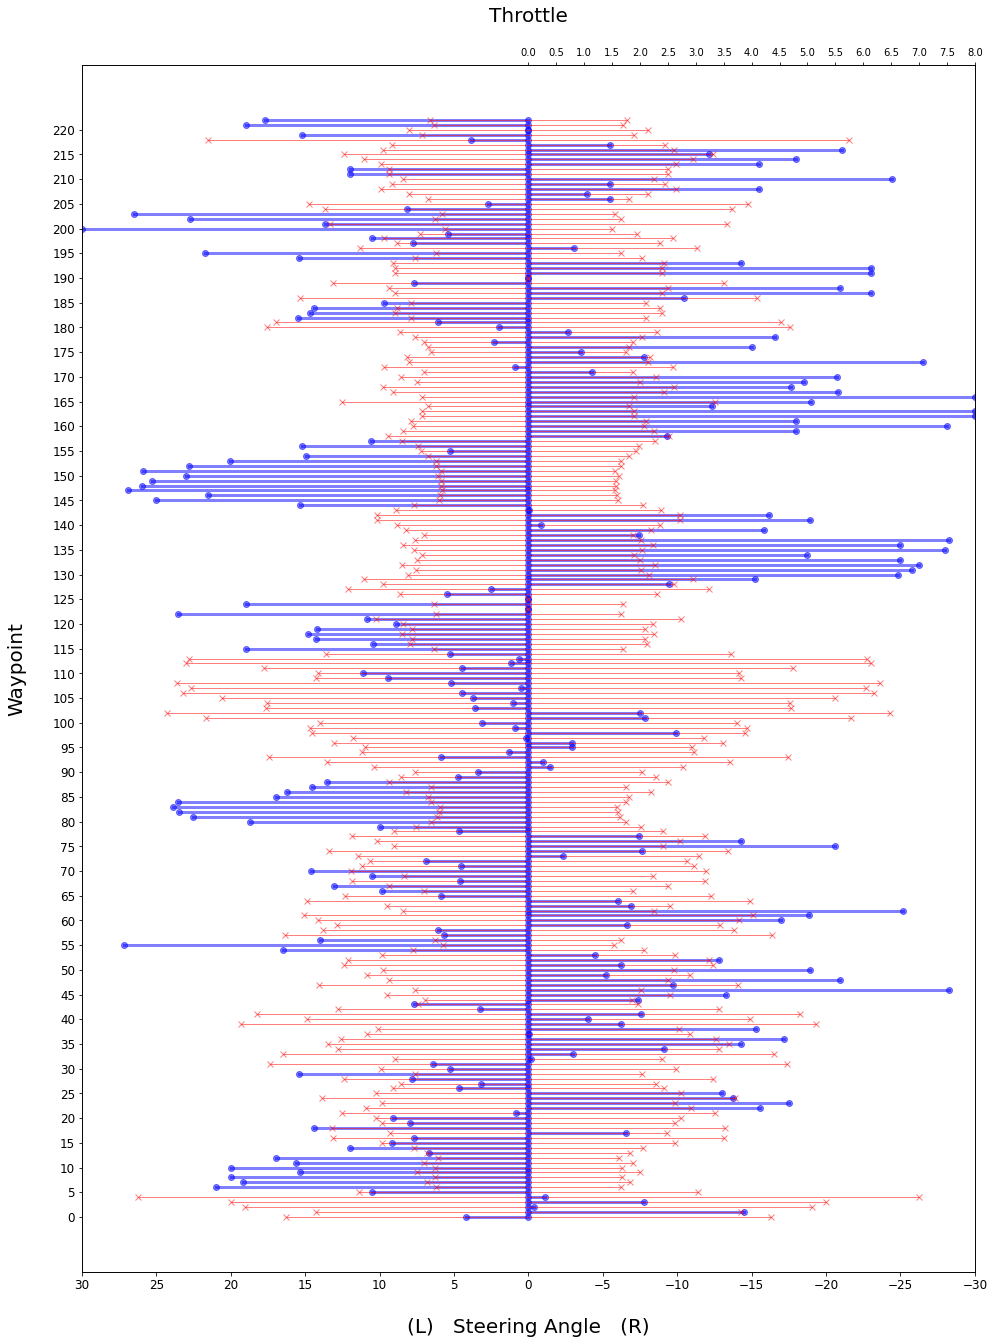

In [47]:
max_iteration = sim_df['iteration'].max()
plot_speedsteering_per_waypoint_v(sim_df[sim_df['iteration']==max_iteration])

# Plot Action / Reward Distribution Heatmap on Track

In [48]:
def plot_x_top_speed_y_top_angle_on_track(df, speed_index, angle_index, less_equal_angle, exact_angle, plot_reward, track_size=(500, 800), x_offset=0, y_offset=0):
    '''
    x_offset, y_offset is used to convert to the 0,0 coordinate system
    '''

    x_highest_speed = 0.0
    if speed_index != 0:
        action_speed_list = action_speed
        action_speed_list.sort()
        x_highest_speed = action_speed_list[-speed_index]
        print('Speed - X Highest: X=%d (%f)' % (speed_index, x_highest_speed))

    y_highest_angle = 0.0
    if angle_index != 0:
        action_steering_list = action_steering
        action_steering_list.sort()
        y_highest_angle = action_steering_list[-angle_index]
        print('Absolute Angle - Y Highest: Y=%d (%f)' % (angle_index, y_highest_angle))
    
    if less_equal_angle >= 0:
        print('Absolute Angle - Less Or Equal: %d' % (less_equal_angle))
        
    if exact_angle != 0:
        print('Absolute Angle - Exact: %d' % (exact_angle))        

    track = np.zeros(track_size) # lets magnify the track by *100
    for index, row in df.iterrows():
        x = int(row["x"]) + x_offset
        y = int(row["y"]) + y_offset
        reward = row["reward"]
        throttle = row["throttle"]
        steer = row["steer"]
        
        if ((throttle == x_highest_speed) or (speed_index == 0)) and ((abs(steer) == y_highest_angle) or (angle_index == 0)) and ((abs(steer) <= less_equal_angle) or (less_equal_angle < 0)) and ((abs(steer) == exact_angle) or (exact_angle == 0)):
            if (plot_reward == True):
                track[y,x] = reward
            else:
                track[y,x] = 1
        
    fig = plt.figure(1, figsize=(plot_x_max/50, plot_y_max/50))
    ax = fig.add_subplot(111)
    print_border(ax, center_line, inner_border, outer_border)
    return track

In [49]:
def plot_x_top_speed_y_top_angle_on_track_for_iteration(curr_iteration, speed_index, angle_index, less_equal_angle, exact_angle, plot_reward):
    max_iteration = sim_df['iteration'].max()
    if (curr_iteration == 0):
        curr_iteration = max_iteration
    df_slice = sim_df[sim_df['iteration']<=curr_iteration]
    df_slice = df_slice[df_slice['iteration']>(curr_iteration-5)]

    track = plot_x_top_speed_y_top_angle_on_track(df_slice, speed_index, angle_index, less_equal_angle, exact_angle, plot_reward, track_size=(plot_y_max, plot_x_max), x_offset=x_offset, y_offset=y_offset)
    title_prefix = ''
    if (plot_reward == True):
        title_prefix = 'Reward '
    plt.title("%sDistribution for X Highest Speed & Y Highest Angle\nAngle Less or Eq to Z & Eq to W\nX: %d / Y: %d / Z: %d / W: %d" % (title_prefix, speed_index, angle_index, less_equal_angle, exact_angle))
    im = plt.imshow(track, cmap='hot', interpolation='bilinear', origin="lower") 

# Plot Reward Distribution Heatmap on Track for the Most Recent Iteration
- Verify that we're not rewarding for bad driving behaviour
- Overlay a heatmap of rewards on the track to identify areas of improvement for the Reward Function; this could also highlight sections where the car is over- and under-steering, or where the car is not driving smoothly

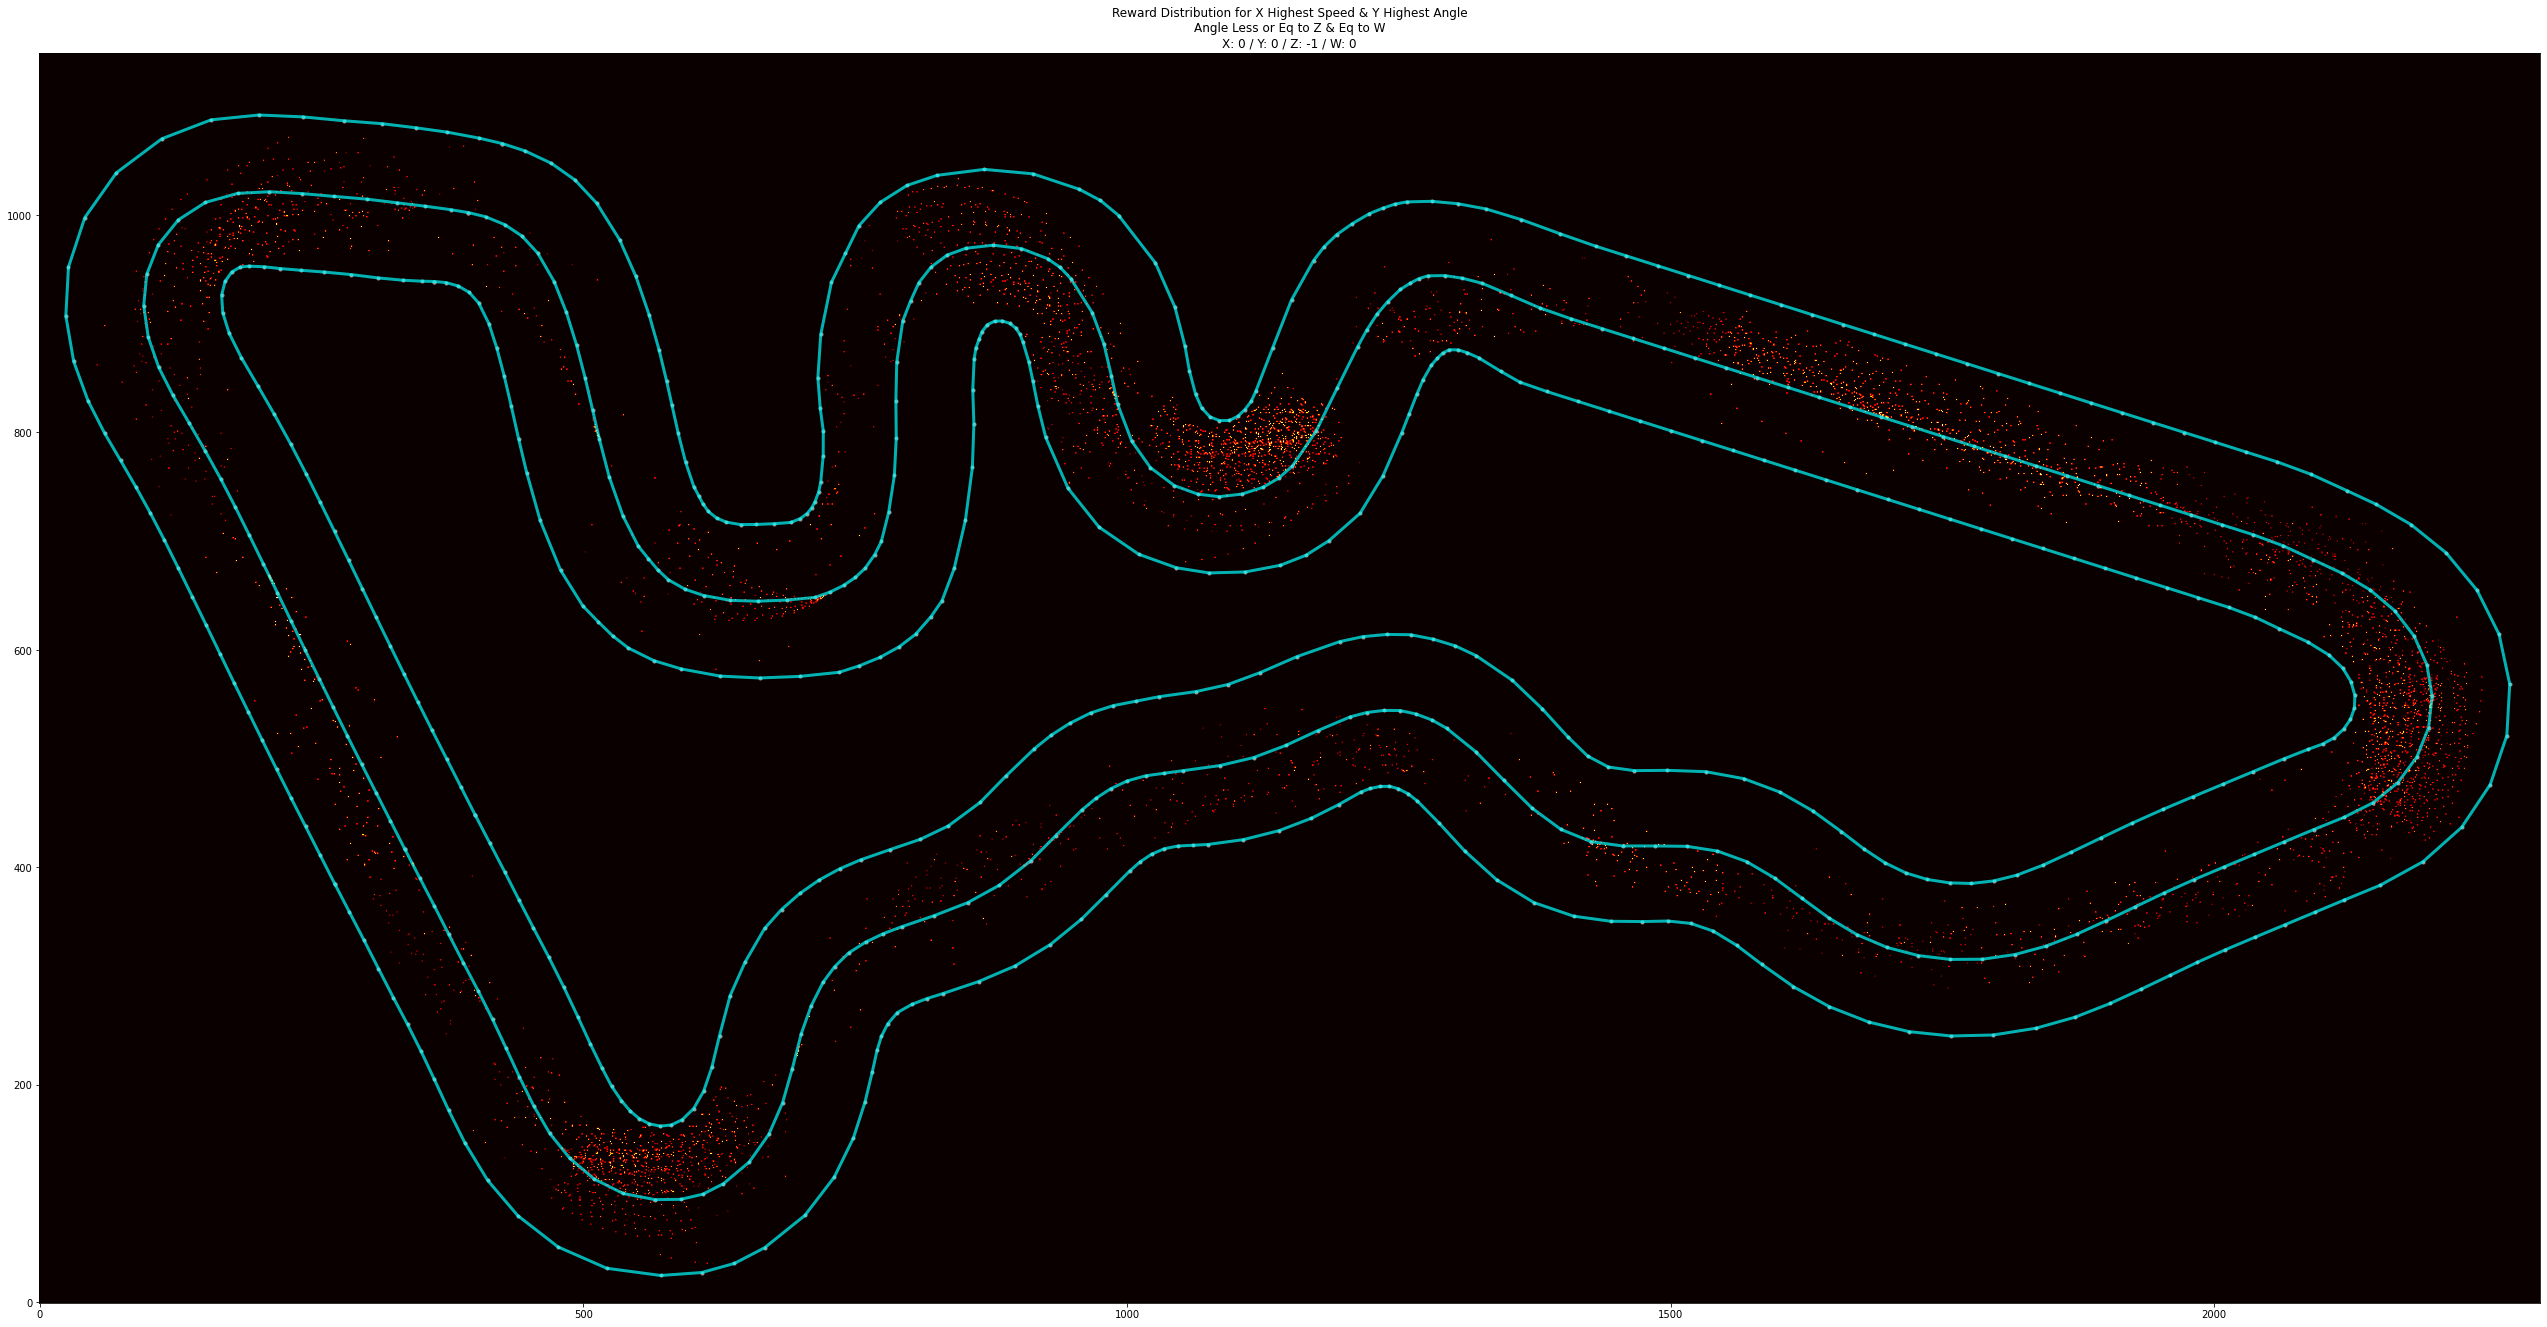

In [50]:
max_iteration = sim_df['iteration'].max()
plot_x_top_speed_y_top_angle_on_track_for_iteration(max_iteration, 0, 0, -1, 0, True)

# Plot Highest-Speed Action Distribution Heatmap on Track for the Most Recent Iteration
- Verify that the model uses the highest speed at appropriate sections of the track (eg., on straights)

Speed - X Highest: X=1 (8.000000)


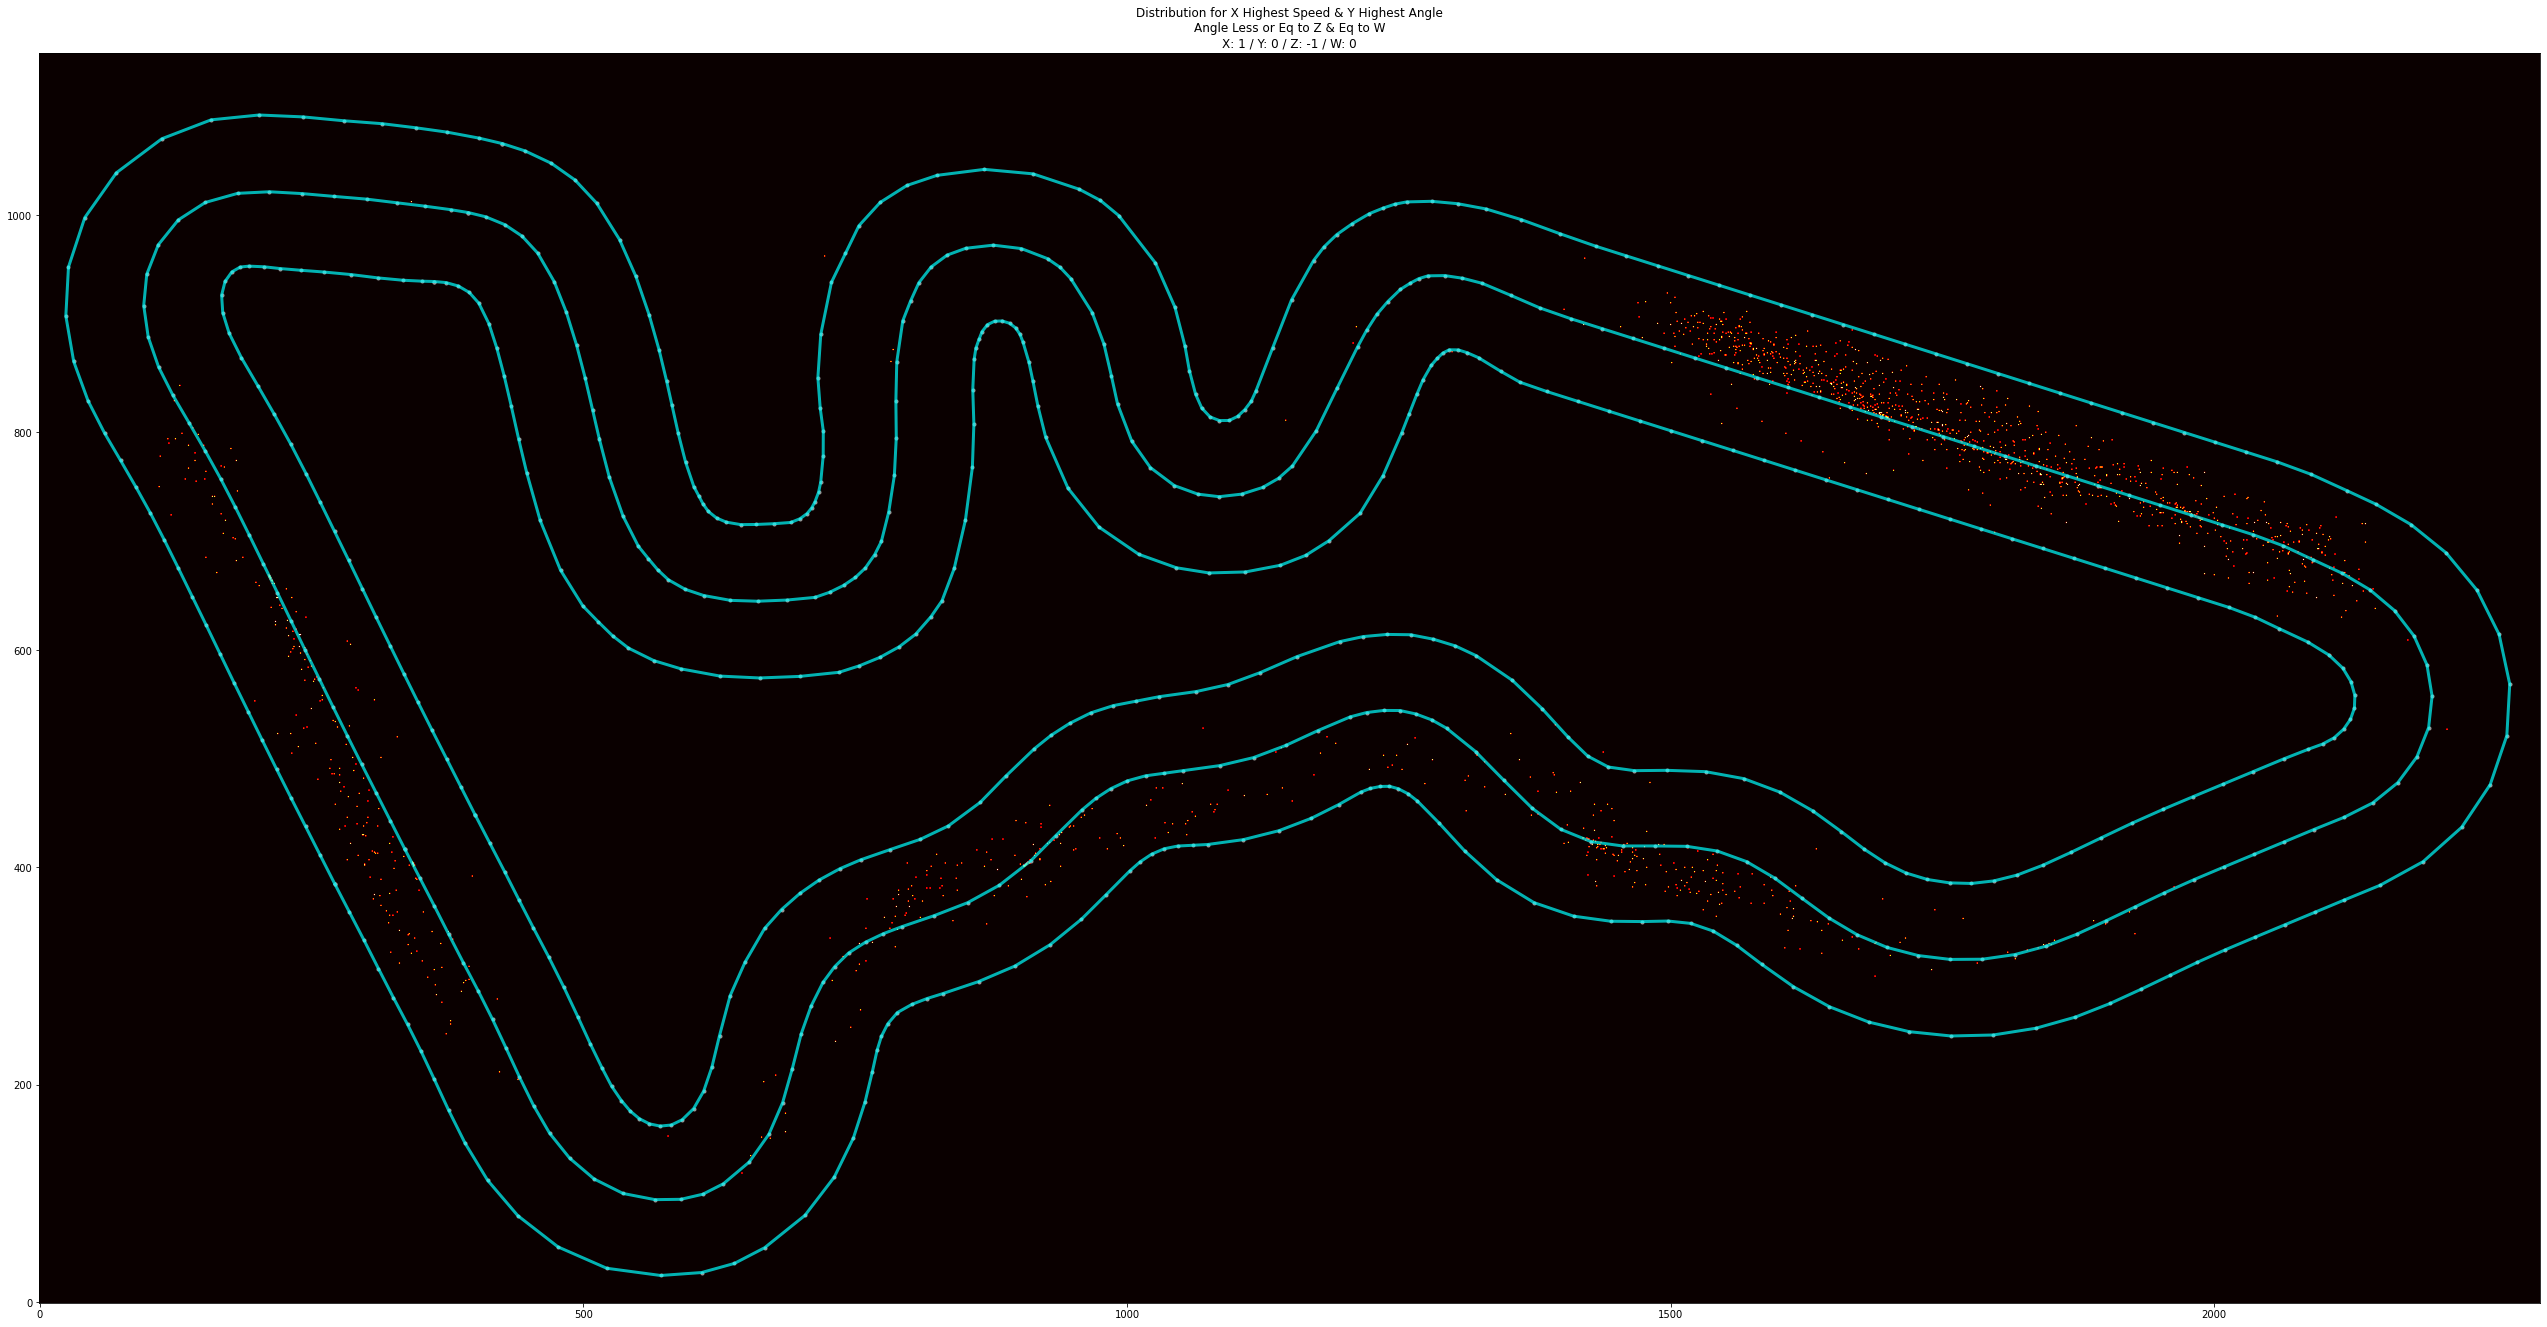

In [51]:
max_iteration = sim_df['iteration'].max()
plot_x_top_speed_y_top_angle_on_track_for_iteration(max_iteration, 1, 0, -1, 0, False)

# Plot 0-Degree Steering Distribution Heatmap on Track for the Most Recent Iteration
- Analyse the various sections of the track where the model is driving straight, to identify sections where we could potentially tweak the actions / rewards

Absolute Angle - Less Or Equal: 0


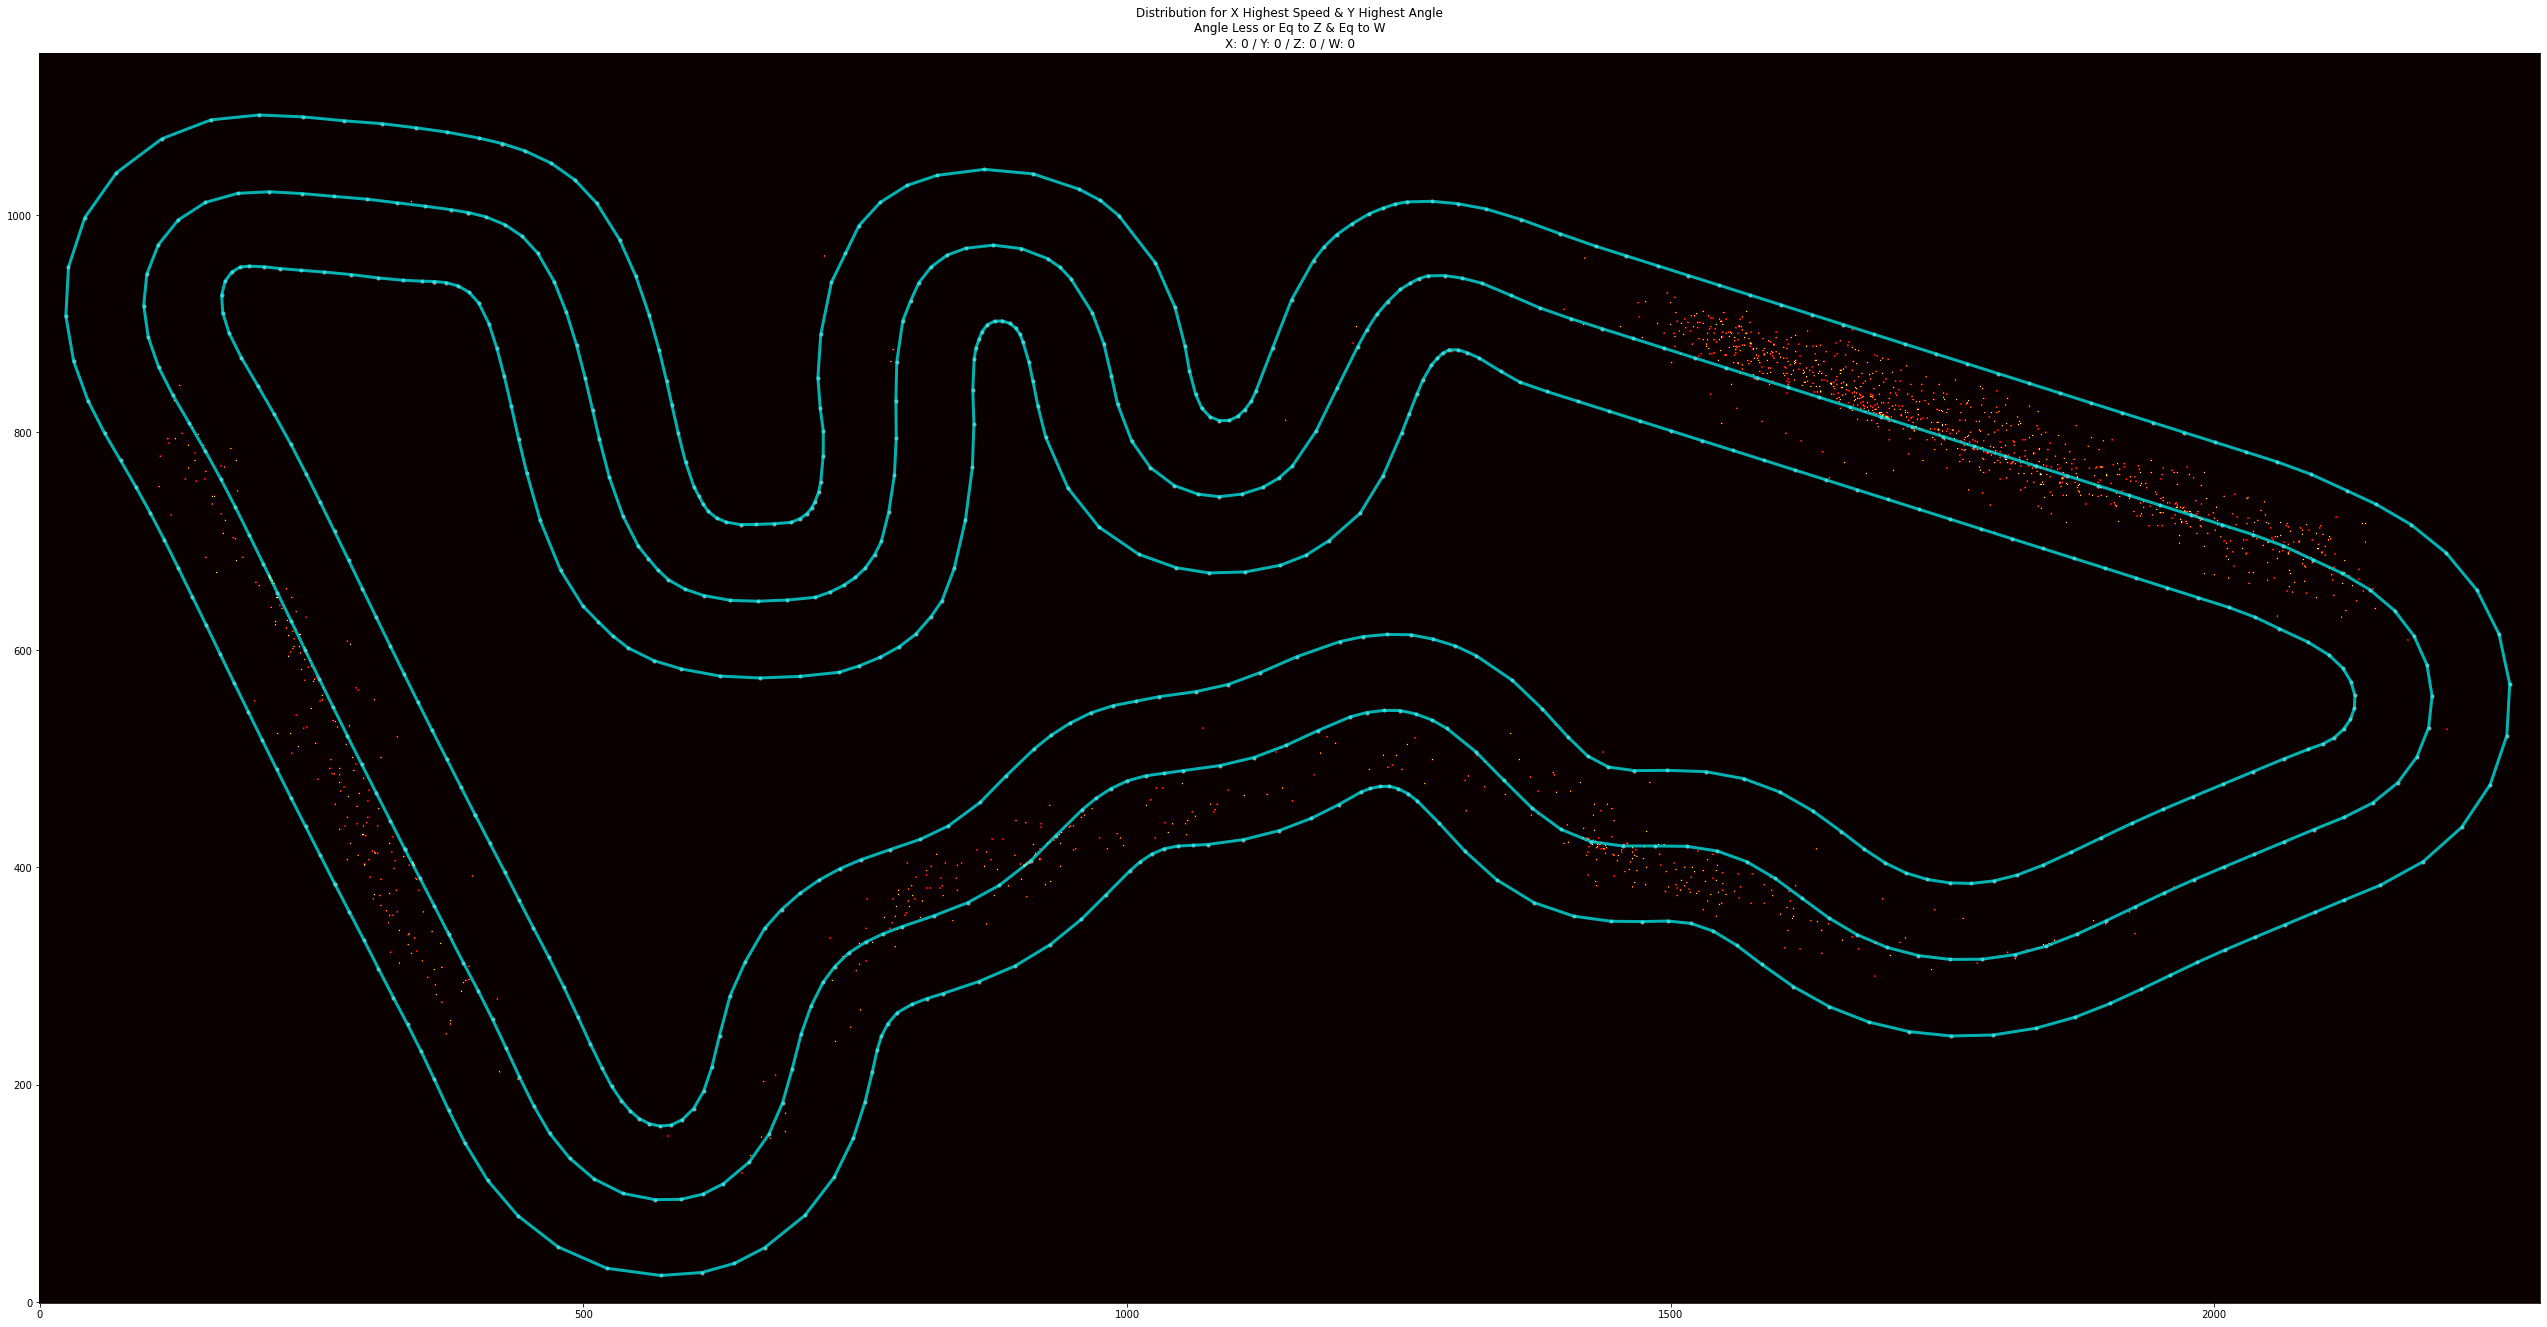

In [52]:
max_iteration = sim_df['iteration'].max()
plot_x_top_speed_y_top_angle_on_track_for_iteration(max_iteration, 0, 0, 0, 0, False)

# Plot Widest Steering-Angle Distribution Heatmap on Track for the Most Recent Iteration
- Analyse the various sections of the track where the model is steering heavily, to identify sections where we could potentially tweak the actions / rewards
- Assumes there are symmetrical -ve and +ve steering angles (otherwise this would plot only the side that has the biggest absolute steering angle value)

Absolute Angle - Y Highest: Y=1 (30.000000)


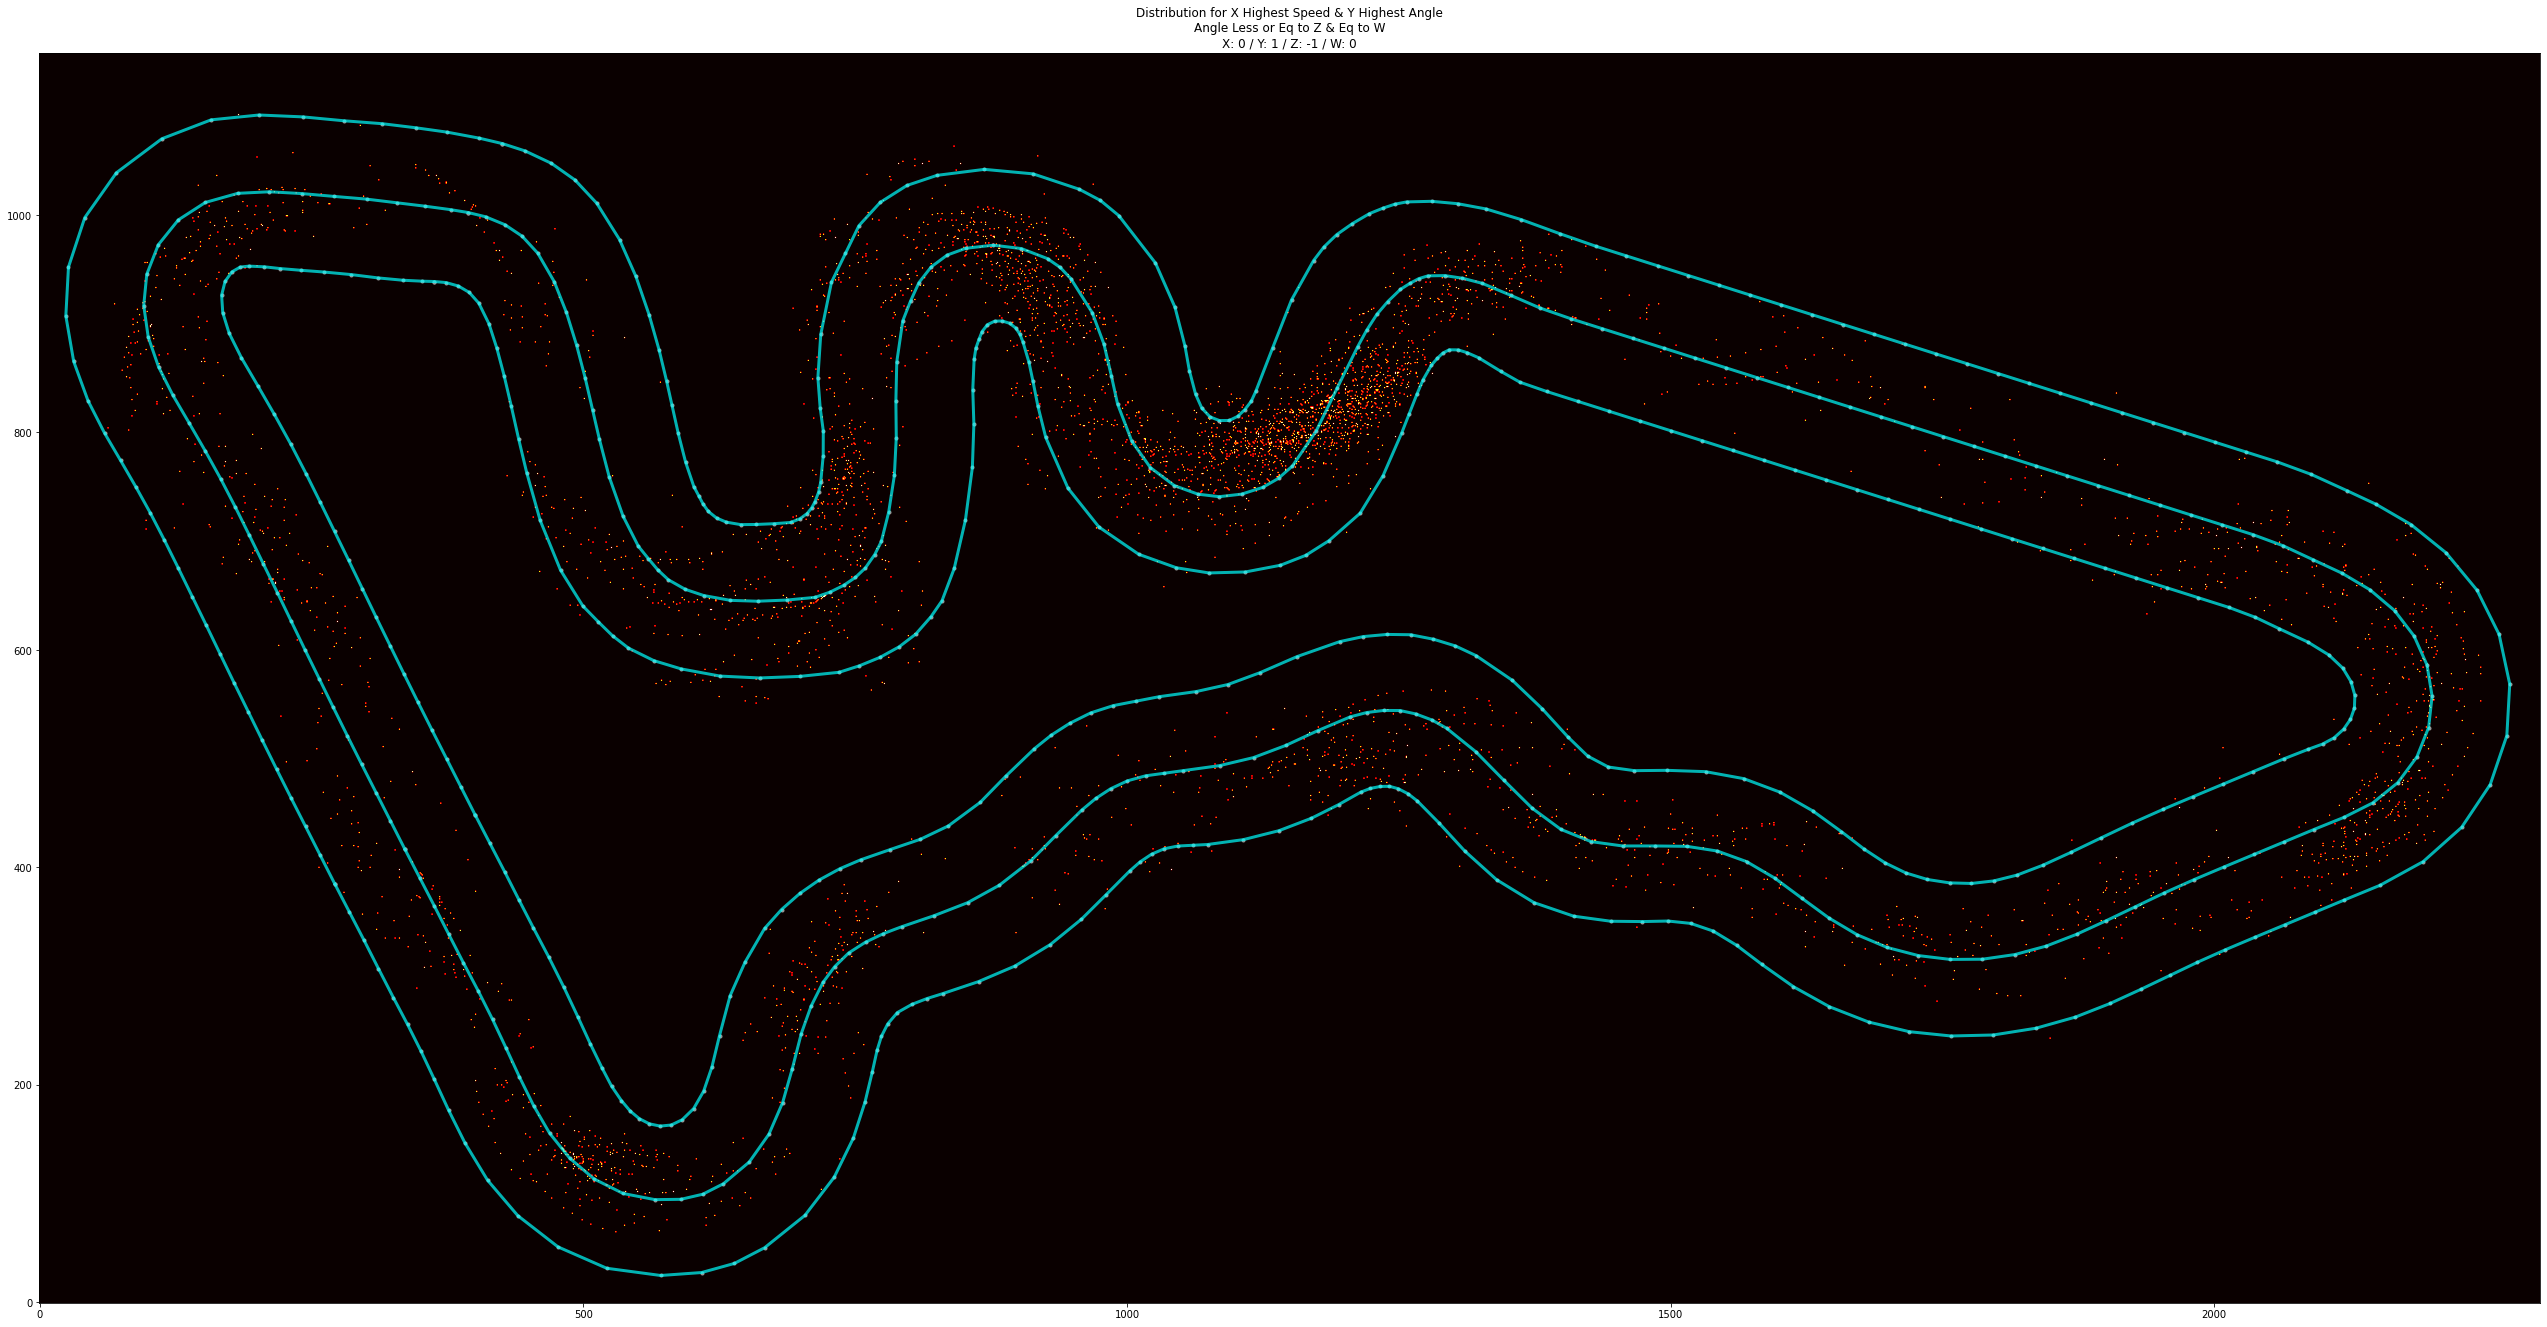

In [53]:
max_iteration = sim_df['iteration'].max()
plot_x_top_speed_y_top_angle_on_track_for_iteration(max_iteration, 0, 1, -1, 0, False)

# Plot Path Taken for the Fastest Completed Lap

In [54]:
def plot_top_laps(sorted_idx, n_laps=5, x_offset=0, y_offset=0, plot_yaw=False, plot_steer=False, plot_labels=False):
    fig = plt.figure(n_laps, figsize=(plot_x_max/50, plot_y_max/50*n_laps))
    for i in range(n_laps):
        ax = fig.add_subplot(n_laps,1,i+1)
        
        line = LineString(center_line)
        plot_coords(ax, line)
        plot_line(ax, line)
        
        line = LineString(inner_border)
        plot_coords(ax, line)
        plot_line(ax, line)

        line = LineString(outer_border)
        plot_coords(ax, line)
        plot_line(ax, line)

        idx = sorted_idx[i]
        episode_data = sim_df[sim_df['episode']==idx]
        episode = sim_df_episodes[sim_df_episodes['episode']==idx]

        plt.title('Episode: %s (Iteration: %d, Episode-in-Iteration: %d), Steps: %d, Progress: %.2f, Rewards: %.2f, Elapsed Time: %.2fs, Status: %s' % (idx, episode['iteration'], episode['episode_in_iteration'], episode['steps'], episode['progress'], episode['episode_total_rewards'], episode['elapsed_time'], episode['status'].values[0]))
        for index, row in episode_data.iterrows():
            x1 = row['x']
            y1 = row['y']
            car_x2, car_y2 = x1 - 0.02, y1
            plt.plot([x1+x_offset, car_x2+x_offset], [y1+y_offset, car_y2+y_offset], 'b.')
            
            if (plot_yaw):
                dx = 5*row['throttle']*math.cos(row['yaw']*math.pi/180)
                dy = 5*row['throttle']*math.sin(row['yaw']*math.pi/180)
                plt.arrow(x1+x_offset, y1+y_offset, dx, dy, linewidth=1, head_width=8, head_length=5, fc='b', ec='b', zorder=99)
    
            if (plot_steer):
                dx = 5*row['throttle']*math.cos((row['yaw']+row['steer'])*math.pi/180)
                dy = 5*row['throttle']*math.sin((row['yaw']+row['steer'])*math.pi/180)
                if row['steer'] < 0:
                    steer_color = 'r'
                elif row['steer'] > 0:
                    steer_color = 'lime'
                else:
                    steer_color = 'y'
                plt.arrow(x1+x_offset, y1+y_offset, dx, dy, linewidth=1, head_width=8, head_length=5, fc=steer_color, ec=steer_color, zorder=99)

            if (plot_labels):
                label_txt = '  STP: %s, WP: %s, HD:%0.2f, STR:%s, THR:%s' % (row['steps'], row['closest_waypoint'], row['yaw'], row['steer'], row['throttle'])
                plt.text(x1+x_offset, y1+y_offset, label_txt)
                print(label_txt)
    return fig



In [55]:
sim_df_episodes_fastest_full_lap = sim_df_episodes[sim_df_episodes['progress']>=100.0].sort_values('elapsed_time', ascending=True).head(1)
sim_df_episodes_fastest_full_lap

iteration  episode_in_iteration  episode  steps  progress  \
230480         47                    35     1915    370     100.0   

              status  episode_total_rewards  elapsed_time    start_time  \
230480  lap_complete               299.0093     24.827577  1.606501e+09   

            end_time  
230480  1.606501e+09

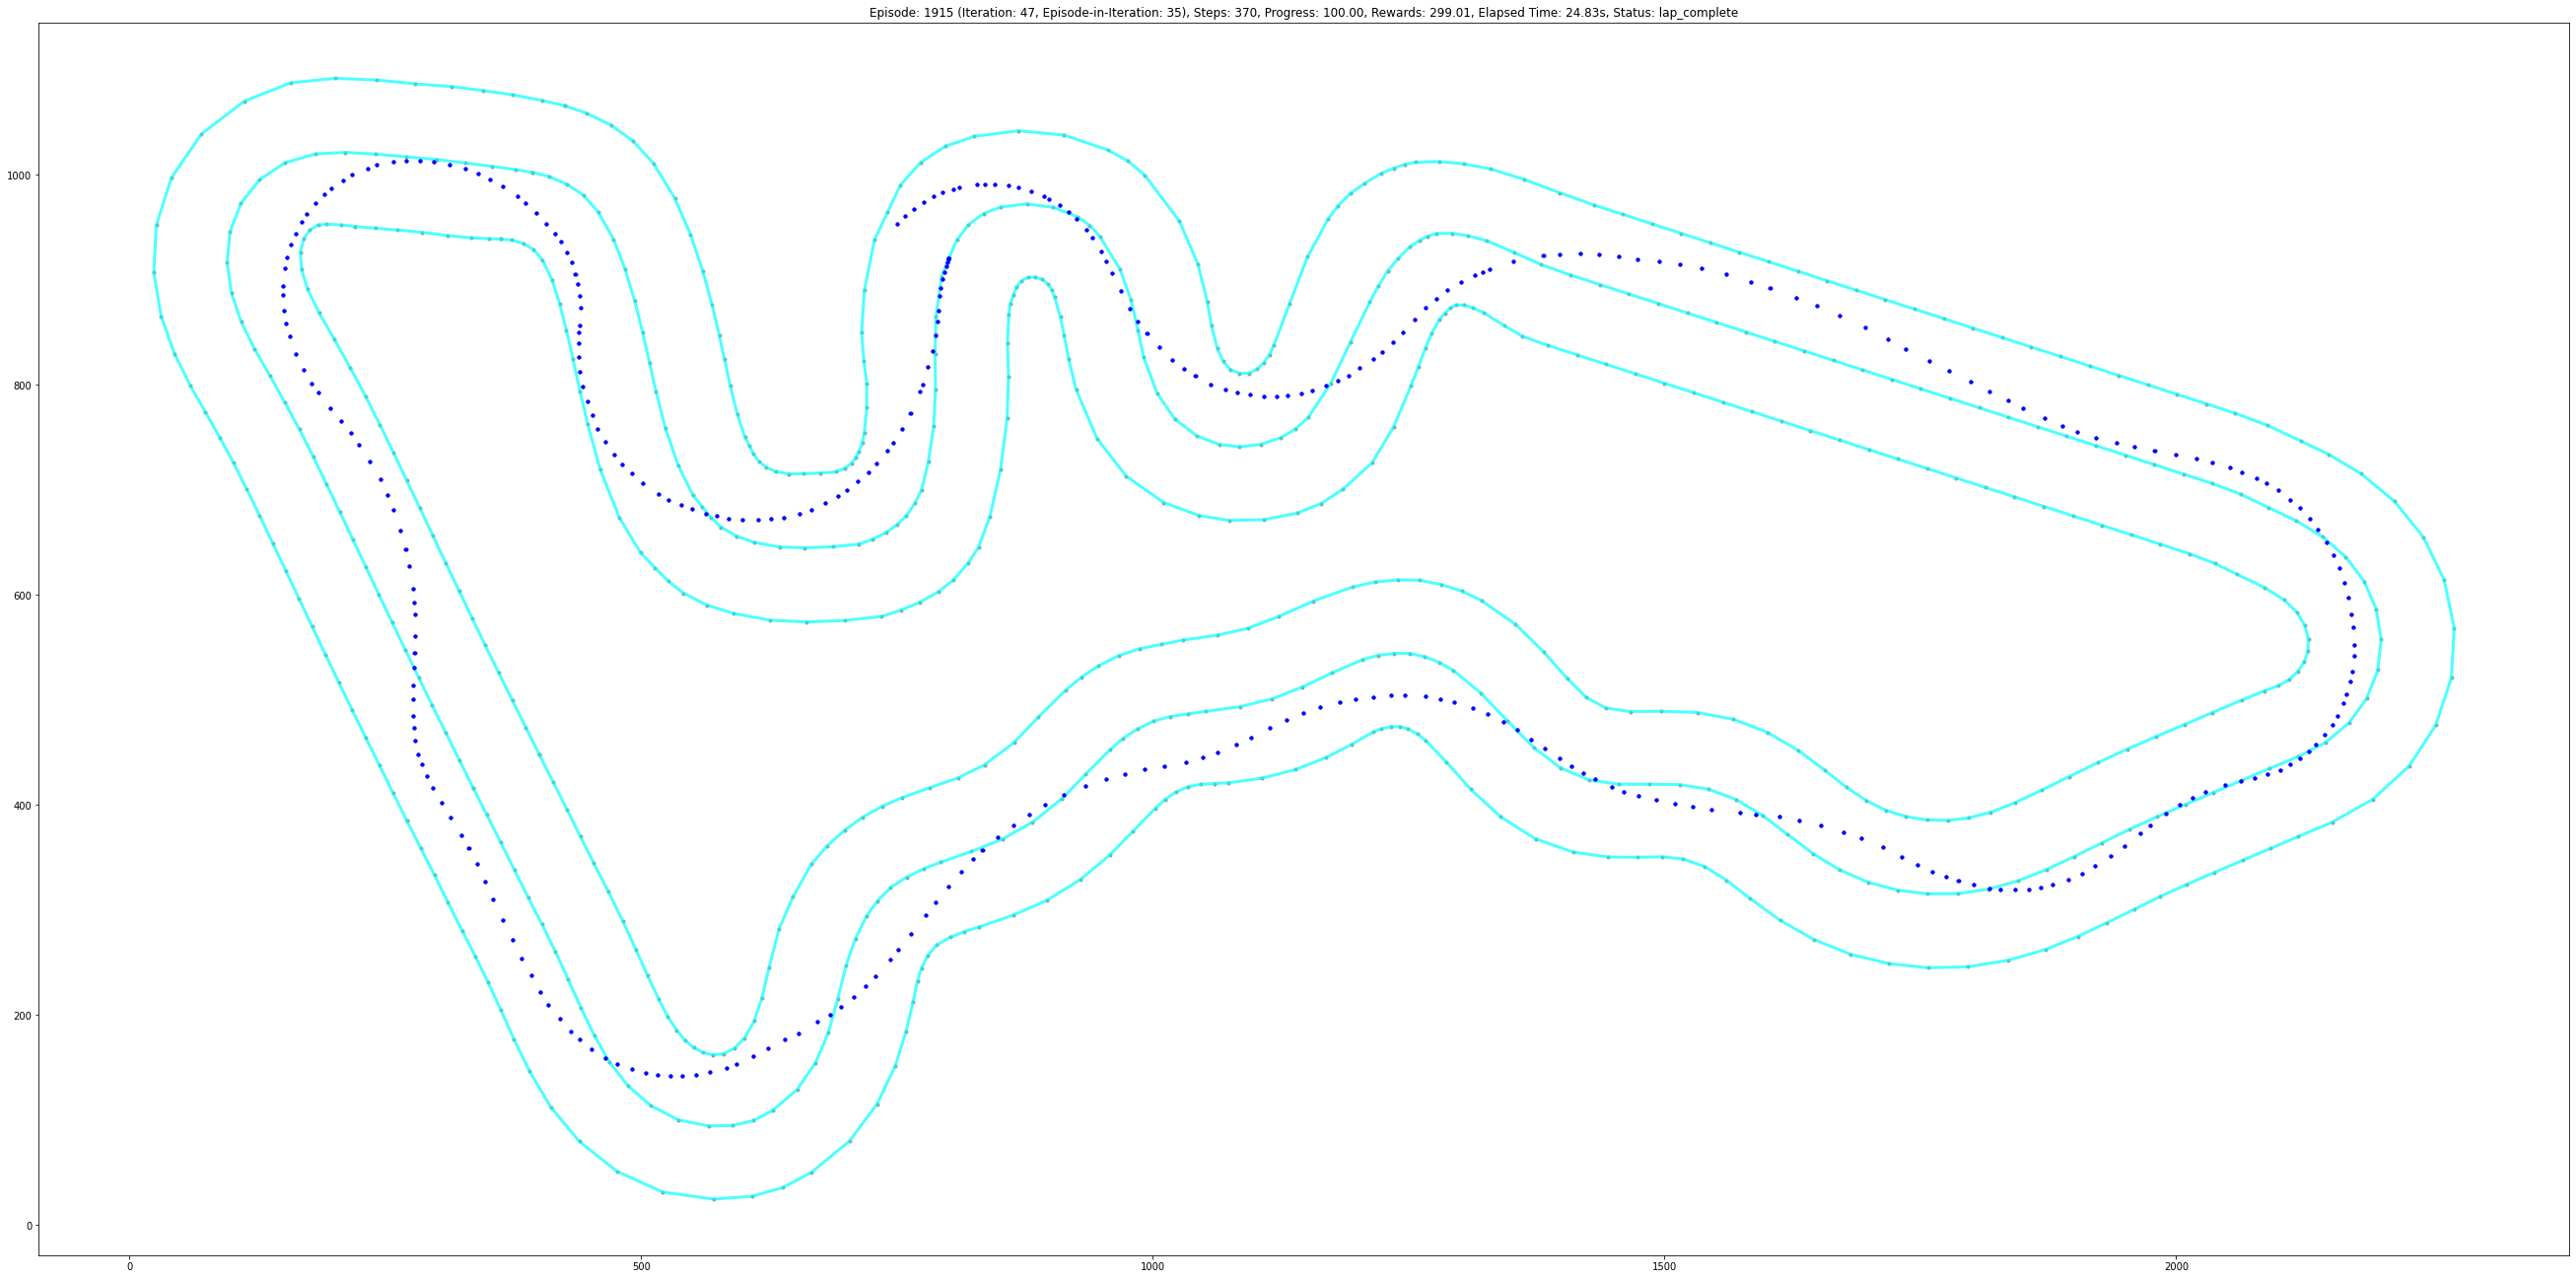

In [56]:
if sim_df_episodes_fastest_full_lap['episode'].count() > 0:
    fig = plot_top_laps(sim_df_episodes_fastest_full_lap['episode'].values, len(sim_df_episodes_fastest_full_lap), x_offset, y_offset)

# Plot the Vectors of the Steps Taken Throughout the Fastest Lap
For any given step:
- Blue arrow indicates the HEADING of the car
- Green arrow indicates that the car is steering LEFT
- Yellow arrow indicates that the car is steering STRAIGHT
- Red arrow indicate that the car is steering RIGHT
- The length of each arrow indicates the relative speed of the car

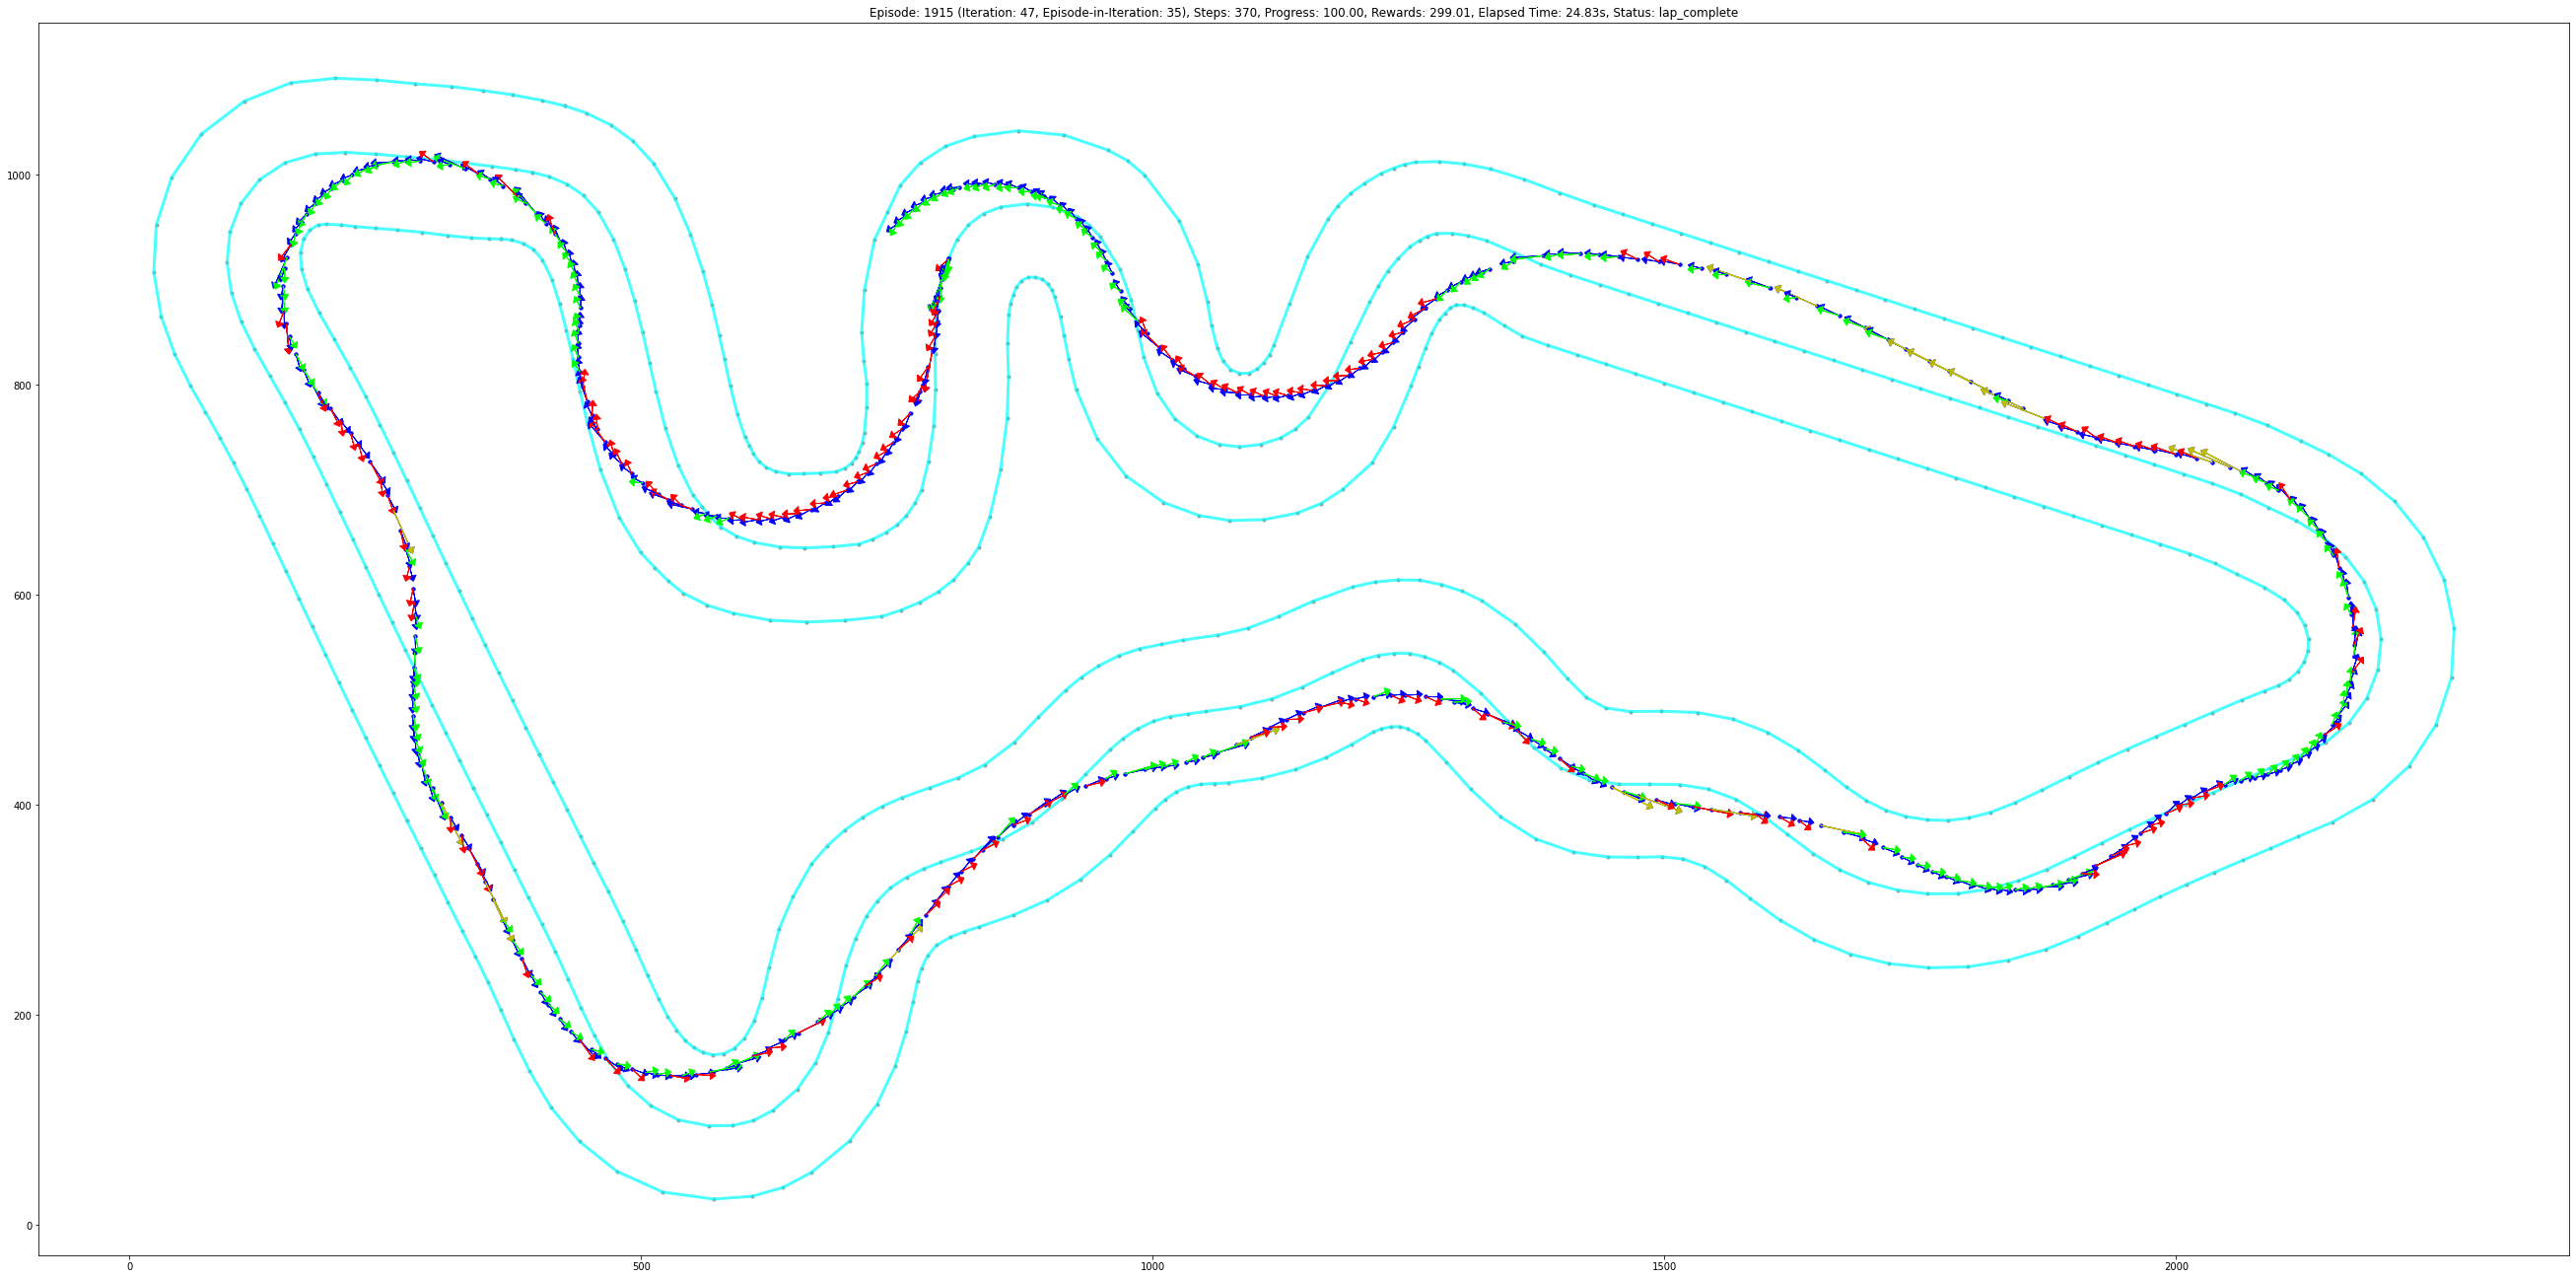

In [57]:
if sim_df_episodes_fastest_full_lap['episode'].count() > 0:
    fig = plot_top_laps(sim_df_episodes_fastest_full_lap['episode'].values, len(sim_df_episodes_fastest_full_lap), x_offset, y_offset, True, True)

In [58]:
print('Done!')

Done!
